# Import Module Library

In [1]:
#Untuk Explore dan Preprocessing Data
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import external
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#Untuk Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

#Untuk Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

#Untuk Evaluasi Model
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, RocCurveDisplay

#Untuk Interpretasi Model
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.inspection import PartialDependenceDisplay

# Module XGBoost Approximator

## Utils

In [2]:
"""
This module contains several functions that are used in various stages of the process
"""
import numpy as np
from sklearn.metrics import roc_curve, auc
import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import random

RANDOM_SEED = 1

def softmax(x):
    """
    This function is useful for converting the aggregated results come from the different trees into class probabilities
    :param x: Numpy k-dimensional array
    :return: Softmax of X
    """
    return np.array([np.exp(x)/np.sum(np.exp(x))])

def get_auc(test_y,y_score):
    """

    :param test_y: Labels
    :param y_score: probabilities of labels
    :return: ROC AUC score
    """
    np.random.seed(RANDOM_SEED)
    classes=[i for i in range(y_score.shape[1])]
    y_test_binarize=np.array([[1 if i ==c else 0 for c in classes] for i in test_y])
    fpr, tpr, _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
    return auc(fpr, tpr)

def train_decision_tree(train,feature_cols,label_col):
    """
    This function gets a dataframe as an input and optimizes a decision tree to the data

    :param train: Pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :return: Trained sklearn decision tree
    """
    np.random.seed(RANDOM_SEED)
    parameters = {'criterion': ['entropy', 'gini'],
                  'max_depth': [3, 5, 10, 20, 50],
                  'min_samples_leaf': [1, 2, 5, 10]}
    model = DecisionTreeClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_



def train_rf_model(train,feature_cols,label_col):
    """
        This function gets a dataframe as an input and optimizes a random forest classifier to the data

        :param train: Pandas dataframe
        :param feature_cols: feature column names
        :param label_col: label column name
        :return: Trained random forest classifier
        """
    np.random.seed(RANDOM_SEED)
    parameters = {'n_estimators':[50,100],
                  'criterion': ['entropy'],
                  'min_samples_leaf': [1, 10, 100],
                  'max_features':['auto','log2']}
    model = RandomForestClassifier()
    clfGS = GridSearchCV(model, parameters, cv=3)
    clfGS.fit(train[feature_cols].values, train[label_col])
    return clfGS.best_estimator_

def train_xgb_classifier(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    np.random.seed(RANDOM_SEED)
    tuning_params = {'colsample_bytree': [0.3,0.5,0.9],
                  'learning_rate': [0.01,0.1],
                  'max_depth': [2,5,10],
                  'alpha': [1,10],
                     'n_estimators':[50,100]}
    if train[label_col].nunique() > 2:
        xgb_params['objective'] = "multi:softprob"
    else:
        xgb_params['objective'] = "binary:logitraw"
    model = xg.XGBClassifier(xgb_params)
    clfGS = GridSearchCV(model, tuning_params, cv=3)
    clfGS.fit(train[feature_cols], train[label_col])
    return clfGS.best_estimator_

def decision_tree_instance_depth(inst, dt):
    """

    :param inst: Instance to be inferenced - numpy vector
    :param dt: sklearn decision tree
    :return: The depth of the leaf that corresponds the instance
    """
    indx = 0
    depth = 0
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    epsilon = 0.0000001
    t = dt.tree_
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return  depth

def decision_tree_depths(test,feature_cols,dt):
    """
    This function is used for calculatingg the prediction depths of each instance that were inferenced by the input
    decision tree

    :param test: Pandas dataframe
    :param feature_cols: feature column names
    :param dt: decision tree
    :return: the depths of leaves that were assigned to each instance
    """
    X = test[feature_cols].values
    return [decision_tree_instance_depth(inst,dt) for inst in X]

#The following are not used:

def train_xgb_classifier2(train,feature_cols,label_col,xgb_params):
    """
    Train an XGBoost to the input dataframe

    :param train: pandas dataframe
    :param feature_cols: feature column names
    :param label_col: label column name
    :param xgb_params: Dict of XGBoost parameters
    :return: label column namened XGboost
    """
    if train[label_col].nunique() > 2:
        obj = "multi:softprob"
    else:
        obj = "binary:logitraw"
    xgb_model = xg.XGBClassifier(**xgb_params)
    xgb_model.fit(train[feature_cols], train[label_col])
    return  xgb_model

def ensemble_prediction_depth(X, rf):
    depths = []
    for inst in X:
        depths.append(np.sum([tree_prediction_depth(inst,base_model.tree_) for base_model in rf.estimators_]))
    return depths

def tree_prediction_depth(inst, t):
    indx = 0
    depth = 0
    epsilon = 0.0000001
    # epsilon: thresholds may be shifted by a very small floating points. For example: x1 <= 2.6 may become x1 <= 2.5999999
    # and then x1 = 2.6 won't be captured
    while t.feature[indx] >= 0:
        if inst[t.feature[indx]] <= t.threshold[indx] + epsilon:
            indx = t.children_left[indx]
        else:
            indx = t.children_right[indx]
        depth += 1
    return depth

def get_features_statistics(data):
    min_values = {col:min(data[col]) for col in data.columns}
    max_values = {col: max(data[col]) for col in data.columns}
    mean_values = {col: np.mean(data[col]) for col in data.columns}
    return min_values, max_values, mean_values

## Conjunction

In [3]:
"""
This module contains the conjunction class

"""
import numpy as np

class Conjunction():
    """
    A conjunction is a combination of feature bounds mapped into a class probability vector
    """
    def __init__(self,feature_names,label_names,leaf_index=None,label_probas=None):
        """
        :param feature_names: list of strings. Also determine the dimensionality
        :param label_names: list of labels. Determines the number of labels too
        :param leaf_index: This feature is optional. Can be relevant if we'd like to document the leaves that were used from the input forest
        :param label_probas: also optional. Relevant if we'd like to determine the class probabilities within the constructor
        """
        self.feature_names = feature_names
        self.number_of_features = len(feature_names)
        self.label_names = label_names

        # upper and lower bounds of the feature for each rule
        self.features_upper = [np.inf] * len(feature_names)
        self.features_lower = [-np.inf] * len(feature_names)

        self.label_probas = np.array(label_probas)
        self.leaf_index = leaf_index

        #The following dict is used for excluding irrelevant merges of different dummy variables that come from the same categorical feature
        self.categorical_features_dict={}

    def addCondition(self, feature, threshold, bound):
        """
        This method adds a condition to the conjunction if relevant (rule isn't already contained in the conjunction)

        :param feature: relevant feature
        :param threshold: upper\lower bound
        :param bound: bound direction

        """
        #Check if the rule isn't already contained in the conjunction
        if bound == 'lower':
            if self.features_lower[feature] < threshold:
                self.features_lower[feature] = threshold
        else:
            if self.features_upper[feature] > threshold:
                self.features_upper[feature] = threshold

        #Address categorical features:
        if '=' in self.feature_names[feature] and threshold >= 1 and bound == 'lower':
            splitted = self.feature_names[feature].split('=')
            self.categorical_features_dict[splitted[0]] = splitted[1]

    def isContradict(self, other_conjunction):
        """
        :param other_conjunction: conjunction object
        :return: True if other and self have at least one contradiction, otherwise False
        """

        #Check upper and lower bounds contradiction
        for i in range(self.number_of_features):
            if self.features_upper[i] <= other_conjunction.features_lower[i] or self.features_lower[i] >=  other_conjunction.features_upper[i]:
                return True

        # check for categorical features contradiction
        for feature in self.feature_names:
            if feature in self.categorical_features_dict and feature in other_conjunction.categorical_features_dict:
                if self.categorical_features_dict[feature] != other_conjunction.categorical_features_dict[feature]:
                    return True

    def merge(self, other):
        """
        :param other: conjunction
        :return: new_conjunction - a merge of the self conjunction with other
        """
        new_conjunction = Conjunction(self.feature_names,self.label_names,
                                      self.leaf_index+other.leaf_index,self.label_probas+other.label_probas)
        new_conjunction.features_upper = [min(i,j) for i,j in zip(self.features_upper,other.features_upper)]
        new_conjunction.features_lower = [max(i, j) for i, j in zip(self.features_lower, other.features_lower)]
        new_conjunction.categorical_features_dict = self.categorical_features_dict
        new_conjunction.categorical_features_dict.update(other.categorical_features_dict)
        return new_conjunction

    def containsInstance(self,inst):
        """
        Checks whether the input instance falls under the conjunction

        :param inst:
        :return: True if
        """
        for i, lower, upper in zip(range(len(inst)), self.features_lower, self.features_upper):
            if inst[i] >= upper or inst[i] < lower:
                return False
        return True

    def has_low_interval(self,lowest_intervals):
        for lower,upper,interval in zip(self.features_lower,self.features_upper,lowest_intervals):
            if upper-lower<interval:
                return True
        return False

    def predict_probas(self):
        """
        :return: softmax of the result vector
        """

        return softmax(self.label_probas)

    def toString(self):
        """
        This function creates a string representation of the conjunction (only for demonstration purposes)
        """
        s = ""
        #save lower bounds
        for feature, threshold in enumerate(self.features_lower):
            if threshold != (-np.inf):
                s +=  self.feature_names[feature] + ' >= ' + str(np.round(threshold,3)) + ", "
        #save upper bounds
        for feature, threshold in enumerate(self.features_upper):
            if threshold != np.inf:
                s +=  self.feature_names[feature] + ' < ' + str(np.round(threshold,3)) + ", "
        #save labels
        s += 'labels: ['
        s+=str(self.label_probas)
        s += ']'
        return s

    #From here on everything is still tested
    def get_data_point(self, min_values, max_values, mean_values):
        X = []
        for i,feature in enumerate(self.feature_names):
            if self.features_lower[i]==-np.inf and self.features_upper[i]==np.inf:
                X.append(mean_values[feature])
            else:
                X.append(np.mean([max(min_values[feature],self.features_lower[i]), min(max_values[feature],self.features_upper[i])]))
        return np.array(X)

## Tree

In [4]:
"""
This module contain a tree class and several functions that are used for constructing the decision tree (stage 2 of the FBT algorithm)
"""

from scipy.stats import entropy

class Tree():
    """
    A decision tree that is based on hierarchical ordering of conjunction set

    Essentialy, the tree is a node with 2 descendents in case of an internal node and a prediction vector if its a leaf
    """

    def __init__(self,conjunctions, splitting_values,max_depth):
        """
        :param conjunctions: A list of conjunctions
        :param splitting_values: A dictionary in ehich keys are features and values are splitting values ordered by frequency
        :param max_depth: Tree maximum depth
        """

        self.conjunctions = conjunctions
        self.splitting_values = splitting_values
        self.max_depth = max_depth

    def split(self):
        # 1. Spliting is stopped if:
        #    a. there's a single conjunctions
        #    b. Entropy doesn't improved
        # 2. Splitting values - at each iteration we selrct the most common value for each feature and selects
        #    The one with the highest information gain
        # 3. Information gain is calculated as the mean emtropy across the different feature dimensions
        if len(self.conjunctions) == 1 or self.max_depth == 0:
            self.selected_feature = None
            self.left = None
            self.right = None
            return
        if len(set([np.argmax(conj.label_probas) for conj in self.conjunctions])) > 1:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_entropy(self.conjunctions, self.splitting_values)
        else:
            self.selected_feature, self.selected_value, self.entropy, \
            l_conjunctions, r_conjunctions = select_splitting_feature_by_max_splitting(self.conjunctions,
                                                                                 self.splitting_values)
        if self.selected_feature is None:
            return
        descending_splitting_values = {k:([i for i in v if i!=self.selected_value] if k == self.selected_feature else v) for k,v in self.splitting_values.items()}
        self.left = Tree(l_conjunctions,descending_splitting_values,max_depth = self.max_depth-1)
        self.right = Tree(r_conjunctions, descending_splitting_values,max_depth = self.max_depth-1)
        self.left.split()
        self.right.split()

    def print_tree(self, feature_cols, prefix='|'):
        print(prefix, end='')
        if self.selected_feature is None:
            # Calculate the mean of the probabilities
            probas = np.array([c.label_probas for c in self.conjunctions])
            mean_probas = probas.mean(axis=0)

            # Determine the class with the highest mean probability
            class_label = np.argmax(mean_probas)
            print('--- Class:', self.conjunctions[0].label_names[class_label])
            return
        print('--- ' + str(feature_cols[self.selected_feature]) + ' >= ' + str(self.selected_value))
        self.left.print_tree(feature_cols, prefix + '   |')
        print(prefix, end='')
        print('--- ' + str(feature_cols[self.selected_feature]) + ' < ' + str(self.selected_value))
        self.right.print_tree(feature_cols, prefix + '   |')


    def predict_instance_proba(self,inst):
        """
        Predicte class probabilities for a given instance

        :param inst: Numpy array. Each dimension is a feature
        :return: class probabilities

        This is a recursive method that routes the instance to its relevant leaf
        """
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]
        if inst[self.selected_feature] >= self.selected_value:
            return self.left.predict_instance_proba(inst)
        else:
            return self.right.predict_instance_proba(inst)

    def get_instance_decision_path(self, inst,result=[]):
        """

        :param inst: numpy array represents an instance to be inferenced
        :param result: a list where each item represents a node
        :return:
        """
        result=list(result)
        if self.selected_feature == None:
            result.append('labels: '+str(np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0]))
            return result
        else:
            if inst[self.selected_feature] >= self.selected_value:
                result.append(str(self.selected_feature)+'>='+str(self.selected_value))
                return self.left.get_instance_decision_path(inst,result)
            else:
                result.append(str(self.selected_feature) + '<' + str(self.selected_value))
                return self.right.get_instance_decision_path(inst, result)

    def predict_proba(self,data):
        """
        Predicted class probabilities for each data instance

        :param data: pandas dataframe
        :return: numpy array with calss probabilities for each data instance
        """
        probas=[]
        for inst in data.values:
            probas.append(self.predict_instance_proba(inst))
        return np.array(probas)

    def predict(self,data):
        return self.predict_proba(data)

    def get_decision_paths(self,data):
        """

        :param data: matrix of [numer_of_instances, number_of_features] dimensions
        :return: A list where each item corresponds to the decision path of one insance
        """
        paths = []
        for inst in data.values:
            paths.append(self.get_instance_decision_path(inst))
        return paths

    # The following methods are relevant for the experimental evaluation. Enable calculating the depth of leaves used for predictions
    def predict_proba_and_depth(self,data):
        probas = []
        depths = []
        for inst in data.values:
            proba, depth = self.predict_instance_proba_and_depth(inst)
            probas.append(proba)
            depths.append(depth)
        return np.array(probas),depths

    def predict_instance_proba_and_depth(self,inst):
        if self.selected_feature == None:
            #return softmax(np.array([c.label_probas for c in self.conjunctions]).sum(axis=0))
            return np.array([softmax(c.label_probas) for c in self.conjunctions]).mean(axis=0)[0], 0
        if inst[self.selected_feature] >= self.selected_value:
            probas, depth = self.left.predict_instance_proba_and_depth(inst)
            return probas, depth + 1
        else:
            probas, depth = self.right.predict_instance_proba_and_depth(inst)
            return probas, depth + 1


def select_splitting_feature_by_entropy(conjunctions, splitting_values):
    """
    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    best_entropy = get_entropy([c.label_probas for c in conjunctions])
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions,temp_entropy = calculate_entropy_for_split(conjunctions,feature, values[i])
            # We want to prevent a case where all the conjunctions are going to one of the descendent
            if temp_entropy < best_entropy and len(temp_l_conjunctions) < conjunctions_len and  len(temp_r_conjunctions) < conjunctions_len:
                best_entropy = temp_entropy
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions
    return selected_feature,selected_value,best_entropy, l_conjunctions, r_conjunctions

def select_splitting_feature_by_max_splitting(conjunctions,splitting_values):
    """

    :param conjunctions: List of conjunctions
    :param splitting_values: A dictionary. Keys are features and values are splitting points, ordered by frequency
    :return: selected feature, splitting value, weighted entropy stemmed from the split, conjunctions of the left node, conjunctions of the right node

    Splitting algorithm:
    1. Define the best entropy as the current entropy of the class probability vectors
    2. For each feature - get the most frequent spliiting value (first item of the dict) and calculate weighted entropy of split
    3. Based on the best entropy - return the derived variables
    """
    conjunctions_len = len(conjunctions)
    #best_entropy = get_entropy([c.label_probas for c in conjunctions])
    best_value = len(conjunctions)
    selected_feature,selected_value,l_conjunctions, r_conjunctions = None, None, None, None
    for feature,values in splitting_values.items():
        if len(values)==0:
            continue
        for i in range(len(values)):#We iterate over all the values within the feature to find the best splitting point
            temp_l_conjunctions, temp_r_conjunctions, temp_value = calculate_max_for_split(conjunctions, feature, values[i])
            if temp_value < best_value:
                best_value = temp_value
                selected_feature = feature
                selected_value = values[i]
                l_conjunctions = temp_l_conjunctions
                r_conjunctions = temp_r_conjunctions

    return selected_feature,selected_value,0, l_conjunctions, r_conjunctions

def calculate_entropy_for_split(conjunctions,feature,value):
    """
    Calculate the entropy of splitting the conjunctions according to the given feature vale

    :param conjunctions: List of conjunctions
    :param feature: splitting feature
    :param value: splitting value
    :return: conjunctions of left and right nodes, weighted entropy
    """
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, calculate_weighted_entropy(l_probas, r_probas)

def calculate_weighted_entropy(l_probas,r_probas):
    """

    :param l_probas: numpy array wehre each item is a probability vector
    :param r_probas: numpy array wehre each item is a probability vector
    :return: weighted entropy
    """
    l_entropy, r_entropy = get_entropy(l_probas), get_entropy(r_probas)
    l_size,r_size = len(l_probas),len(r_probas)
    overall_size = l_size+r_size
    return(l_size*l_entropy+r_size*r_entropy)/overall_size


def get_entropy(probas):
    """
    Calculate antropy of an array of class probability vectors
    :param probas: An array of class probability vectors
    :return: the average entropy of each class vector
    """
    values = np.array([np.argmax(x) for x in probas])
    values, counts = np.unique(values, return_counts=True)
    probas = counts / np.sum(counts)
    return entropy(probas)

def calculate_max_for_split(conjunctions,feature,value):
    l_conjunctions = []
    r_conjunctions = []
    l_probas = []
    r_probas = []
    for conj in conjunctions:
        if conj.features_upper[feature] <= value:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
        elif conj.features_lower[feature] >= value:
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
        else:
            r_conjunctions.append(conj)
            r_probas.append(conj.label_probas)
            l_conjunctions.append(conj)
            l_probas.append(conj.label_probas)
    return l_conjunctions, r_conjunctions, max(len(l_conjunctions),len(r_conjunctions))

## Pruning

In [5]:
"""
This module contain the Pruner function for pruning a decision forest
"""
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

class Pruner():
    """
    A static class that supports the pruning of a decision forest
    """
    def predict_probas_tree(self,conjunctions,X):
        """
        Predict probabilities for X using a tree, represented as a conjunction set

        :param conjunctions: A list of conjunctions
        :param X: numpy array of data instances
        :return: class probabilities for each instance of X
        """

        probas = []
        for inst in X:
            for conj in conjunctions:
                if conj.containsInstance(inst):
                    probas.append(conj.label_probas)
        return np.array(probas)
    def predict_probas(self,forest,X):
        """
        Predict probabilities of X, using a decision forest

        :param forest: A list of decision trees where each tree is a list of conjunctions
        :param X: Numpy array of data instances
        :return: List of class probabilities vector
        """
        predictions = []
        if isinstance(X, pd.DataFrame):
            X = X.values
        for t in forest:
            predictions.append(self.predict_probas_tree(t, X))
        return np.array([softmax(pred)[0] for pred in np.array(predictions).sum(axis=0)])

    def predict(self,forest,X):
        """
            Predict labels of X, using a decision forest

            :param forest: A list of decision trees where each tree is a list of conjunctions
            :param X: Numpy array of data instances
            :return: class vector
        """
        return np.argmax(self.predict_probas(forest,X),axis=1)

    def get_forest_auc(self,forest,X,Y):
        """
        Calculates predictions ROC AUC

        :param forest: A list of lists of conjunctions
        :param X: Numpy array of data instances
        :param Y: Label vector
        :return: ROC AUC
        """
        y_probas = self.predict_probas(forest,X)
        return get_auc(Y,y_probas)

    def forests_kappa_score(self,probas1,probas2):
        """
        Calculates Cohen's kappa of the predictions divided from two vectors of class probabilities

        :param probas1: list of class probabilities
        :param probas2: list of class probabilities
        :return: Cohen's kappa
        """

        predictions1 = np.array([np.argmax(i) for i in probas1])
        predictions2 = np.array([np.argmax(i) for i in probas1])
        return cohen_kappa_score(predictions1,predictions2)

    def kappa_based_pruning(self,forest,X,Y,min_forest_size=10):
        """
        This method conduct a kappa-based ensemble pruning.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble

        The algorithm contains the following stages:
        1. Add the tree with the highest AUC for X to the new (empty) forest
        2. At each iteration add the tree with the highest cohen's kappa in relation to the new forest
        3. Stop when the new forest AUC doesn't improve and minimum forest size was reached
        """

        selected_indexes = [np.argmax([self.get_forest_auc([t],X,Y) for t in forest])] #Include only the tree with the best AUC
        previous_auc = 0
        current_auc = get_auc(Y,self.predict_probas([forest[selected_indexes[0]]],X))
        new_forest = [forest[selected_indexes[0]]]
        while current_auc > previous_auc or len(new_forest) <= min_forest_size:
            kappas = [1 if i in selected_indexes else self.forests_kappa_score(new_forest,[t],X) for i,t in enumerate(forest)]
            new_index = np.argmin(kappas)
            if new_index in selected_indexes:
                break
            selected_indexes.append(new_index)
            previous_auc = current_auc
            new_forest.append(forest[new_index])
            current_auc = get_auc(Y,self.predict_probas(new_forest,X))
        return new_forest

    def max_auc_pruning(self, forest, X, Y, min_forest_size=10):
        """
        This method conduct an ensemble pruning using a greedy algorithm that maximizes the AUC on the given dataset.

        :param forest: A list of lists of conjunctions (a decision forest)
        :param X: Numpy array (data instances)
        :param Y: Label vector
        :param min_forest_size: minimum size of the pruned ensemble
        :return: list of lists of conjunctions - represents the pruned ensemble
        """
        X = X.values
        trees_predictions = {i: self.predict_probas_tree(forest[i],X) for i in range(len(forest))} #predictions are stored beforehand for efficiency purposes
        selected_indexes = [np.argmax([get_auc(Y,trees_predictions[i]) for i in trees_predictions])] #get the tree with the highest AUC for the given dataset
        previous_auc = 0
        best_auc = get_auc(Y,trees_predictions[selected_indexes[0]])
        while best_auc > previous_auc or len(selected_indexes) <= min_forest_size:
            previous_auc = best_auc
            best_index = None
            for i in range(len(forest)):
                if i in selected_indexes:
                    continue
                probas = np.array([trees_predictions[indx] for indx in selected_indexes + [i]]) #get the probas given by each tree, included the tested one
                probas = np.array([softmax(prob)[0] for prob in probas.sum(axis=0)]) #aggregate the predictions
                temp_auc = get_auc(Y,probas)
                if temp_auc > best_auc or best_index==None:
                    best_auc = temp_auc
                    best_index = i
            selected_indexes.append(best_index)
        print('Pruned forest training set AUC: '+str(best_auc))
        return [t for i,t in enumerate(forest) if i in selected_indexes]



## Tree Extraction

In [7]:
"""
This module contains functions for extracting information of individual trees from XGBoost
"""

import re
#internal node parser:
feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')

#leaf parser:
leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')

def extractNodesFromModel(model):
    """
    Extract decision trees from XGBoost.

    :param model: XGBoost model
    :param feature_dict: {feature_name: feature_index}
    :return: trees: List of trees where trees represented as lists of dictionaries. Each dictionary represents a node within the corresponding tree
    """
    trees= []
    for tree_string in model._Booster.get_dump():
        nodes = [feature_regex.search('t' + node).groupdict() if '[' in node else leaf_regex.search('t' +node).groupdict() for node in tree_string.split('\n')[:-1]]
        trees.append(nodes)
    return trees

def extractClassValue(tree,leaf_index,label_names,class_index):
    """
    This function takes a leaf index and convert the class logit into a probability

    :param tree: dictionary that represents a decision tree
    :param leaf_index: leaf index - integer
    :param label_names: list of strings - labels
    :param class_index: index of the addressed class
    :return: class probabilitis
    """
    pred = float(tree[leaf_index]['prediction'])
    if len(label_names)>2:
        return [pred if i == class_index else 0 for i in range(len(label_names))]
    else:
        p = 1 / (1 + np.exp(pred))
        return [p,1-p]
def extractConjunctionsFromTree(tree, tree_index,leaf_index, feature_dict, label_names, class_index):
    """
    Covert the leaves of a tree into a set of conjunctions

    :param tree: list of dictionaries where each dictionary represents a node within a tree
    :param leaf_index: index of the currently processed node
    :param feature_dict: {feature name: feature index} - for converting xgboost feature names to conjunction feature indices
    :param label_names: possible class values
    :param class_index: currently addressed class - since each model is basically a binary classification of tree of a single class it's impoertant to know the relevant class
    :return: A set of conjunctions
    """
    if 'prediction' in tree[leaf_index]:
        probas = extractClassValue(tree,leaf_index,label_names,class_index)
        return [Conjunction(list(feature_dict.keys()),label_names,
                            leaf_index=[str(tree_index)+'_'+str(leaf_index)],label_probas=probas)]
    l_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['left']),feature_dict,label_names,class_index)
    r_conjunctions = extractConjunctionsFromTree(tree,tree_index,int(tree[leaf_index]['right']),feature_dict,label_names,class_index)
    for c in l_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'upper')
    for c in r_conjunctions:
        c.addCondition(feature_dict[tree[leaf_index]['feature']],float(tree[leaf_index]['value']),'lower')
    return l_conjunctions + r_conjunctions

def merge_two_conjunction_sets(conj_list1,conj_list2):
    """
    Gets two conjunction sets and return a set that is a cartesian product of the two input sets

    :param conj_list1:
    :param conj_list2:
    :return:
    """
    new_conjunction_list=[]
    for c1 in conj_list1:
        for c2 in conj_list2:
            if not c1.isContradict(c2):
                new_conjunction_list.append(c1.merge(c2))
    return new_conjunction_list

def postProcessTrees(conjunction_sets, num_of_labels):
    """
    This function is used for integrating mulitple binary trees into a single tree of multiple labels

    :param conjunction_sets: list of lists of conjunctions
    :param num_of_labels: number of labels in the dataset that was used for training
    :return: new list of conjunctions
    """

    new_conj_list = []
    for i in range(0, len(conjunction_sets), num_of_labels):
        conj = conjunction_sets[i]
        for j in range(i + 1, i + num_of_labels):
            conj = merge_two_conjunction_sets(conj, conjunction_sets[j])
        new_conj_list.append(conj)
    return new_conj_list

def extractConjunctionSetsFromForest(model,unique_labels,features):
    """
    This function takes XGBoost model and returns a list of trees where each tree is represented as a list of conjunctions.
    Each of the tree conjunctions stands for a single decision path

    :param model: XGBoost model
    :param unique_labels: label names
    :param features: feature names
    :return: a list of conjunctions
    """

    trees = extractNodesFromModel(model)
    num_of_labels = len(unique_labels)
    feature_dict = {v:k for k,v in enumerate(features)}
    conjunction_sets = {}
    for i,t in enumerate(trees): #i stands for the corresponding class index
        indexed_tree = {int(v['node_index']): v for v in t}
        conjunction_sets[i] = extractConjunctionsFromTree(indexed_tree,i,0, feature_dict, unique_labels, i % num_of_labels)
    if num_of_labels > 2:
        return postProcessTrees(conjunction_sets,num_of_labels)
    else:
        return list(conjunction_sets.values())

## Conjunction Set

In [8]:
"""
This module contains the ConjunctionSet class
"""

from statsmodels.distributions.empirical_distribution import ECDF

from collections import Counter

from pyod.models.knn import KNN
from pyod.models.lof import LOF

class ConjunctionSet():
    """
    ConjunctionSet is a class that represents a set of conjunctions.

    This is the output of stage 1.
    Each conjunction at the given set represents a possible combination of leaves from the source decision forests.
    """

    def __init__(self, max_number_of_conjunctions=np.inf, filter_method='probability'):
        """
        :param max_number_of_conjunctions: Number of maximum allowed conjunctions at each iteration
        :param filter_method: The approach that will be takes for filtering conjunctions
        """
        self.filter_method = filter_method
        self.max_number_of_conjunctions = max_number_of_conjunctions

    def fit(self,trees_conjunctions,data,feature_cols,label_col, int_features = []):
        """

        :param trees_conjunctions: Decision forest given as a list of lists of conjunction objects.
        :param data: pandas dataframe that was used for training the decision forest
        :param feature_cols: Feature names in the dataframe
        :param label_col: label column name
        :param int_features: list of integer feartures
        :return: set a list of conjunction set that best represents the decision forest
        """
        self.feature_cols = feature_cols
        self.labels = data[label_col].unique()
        self.trees_conjunctions = trees_conjunctions
        self.int_features = int_features

        #Create an ECDF for each feature
        self.set_probability_ecdf(data)


        #Extract all the leaf combinations that were applied for training data:
        print('Create conjunction set from training data instances')
        self.create_conjunction_set_from_data(data)


        #set maximum number of conjunctions per label
        print('Create complete conjunction set')
        self.calculate_max_conjunctions_per_label(data,label_col)

        # Run the algorithm of creating the complete conjunction set:
        self.createConjunctionSetFromTreeConjunctions()

        #Merge the two conjunctions:
        self.conjunctions = self.conjunctions + self.training_conjunctions

        #Get the ordered splitting points for creating the hierarchy at stage 2
        self.set_ordered_splitting_points()

    def createConjunctionSetFromTreeConjunctions(self):
        """
        This method generates the conjunction set (stage 1) from the decision forest
        """
        self.conjunctions = self.trees_conjunctions[0] #Define the first tree as the current conjunction set
        i = 1
        self.size_per_iteration = [len(self.conjunctions)]
        while i < len(self.trees_conjunctions): #At each iteration we merge the next tree with the current conjunction set
            self.conjunctions= merge_two_conjunction_sets(self.conjunctions, self.trees_conjunctions[i])
            i+=1
            self.filter() #Filter redundant conjunction according to the filtering strategy
            self.size_per_iteration.append(len(self.conjunctions))
            print('Size at iteration '+str(i)+': '+str(len(self.conjunctions)))
    def filter(self):
        """
        This method filters the current conjunction set according to the filtering strategy.

        At the first stage it filters conjunctions that contain irrelevant integer rules.
        For example: If x is an integer then a conjunction that contains  5.5 >= x < 6 is filtered out
        """
        self.conjunctions = [conj for conj in self.conjunctions if self.int_filter(conj)]
        if len(self.conjunctions)<=self.max_number_of_conjunctions:
            return
        if self.filter_method == 'probability':
            self.filter_by_probability()
        if self.filter_method == 'probability_label':
            self.filter_by_probability_labels()
        elif self.filter_method == 'knn':
            self.filter_by_knn()
        elif self.filter_method == 'LOF':
            self.filter_by_lof()

    def filter_by_probability(self,EPSILON=0.00001):
        """
        This method filters conjunctions according to the product of each rule ECDF

        :param EPSILON: Prevent a case of probability = 0

        """
        independent_probs = []
        for conj in self.conjunctions:
            independent_probs.append(np.sum(np.log([self.ecdf[col](conj.features_upper[col])-self.ecdf[col](conj.features_lower[col])+EPSILON for
                                                         col in range(len(self.feature_cols))])))
        max_value = sorted(independent_probs, reverse=True)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c,val in zip(self.conjunctions,independent_probs) if val >= max_value] #It actually includes a little more than max_number_of conjunctions due to the >=

    def predict(self,X):
        return [np.argmax(i) for i in self.predict_proba(X)]

    def predict_proba(self,X):
        predictions = []
        if isinstance(X,pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            for conjunction in self.conjunctions:
                if conjunction.containsInstance(inst):
                    predictions.append(np.exp(conjunction.label_probas) / np.sum(np.exp(conjunction.label_probas), axis=0)) #softmax
                    break
        return np.array(predictions)

    #Filtering functions

    def set_probability_ecdf(self,data):
        self.ecdf = {i:ECDF(data[col].values) for i,col in enumerate(self.feature_cols)}

    def set_minimum_intervals(self,data):
        intervals = {col: data[col].diff().sort_values().dropna().values for col in self.feature_cols}
        self.minimum_intervals = [x[x > 0].min()*self.min_interval_ratio for col, x in intervals.items()]

    def int_filter(self,conj,EPSILLON=0.00001):
        for i,feature in enumerate(self.feature_cols):
            if feature in self.int_features:
                if conj.features_upper[i]-conj.features_lower[i]-EPSILLON <= 0.5 and (conj.features_lower[i] % 1) > 0:
                    return False
        return True

    def create_conjunction_set_from_data(self,X):
        """

        :param X: Pandas dataframe (or matrix)
        :return: training_conjunctions - all the conjunctions that were applied for X
        """
        participated_leaves = []
        self.training_conjunctions = []
        if isinstance(X, pd.DataFrame):
            X = X[self.feature_cols].values
        for inst in X:
            s=''
            conj = Conjunction(self.feature_cols,self.labels,leaf_index=[],label_probas=np.zeros(len(self.labels))) #Define the conjunction
            for tree_index,tree in enumerate(self.trees_conjunctions):
                for leaf_index,leaf in enumerate(tree):
                    if leaf.containsInstance(inst):
                        conj = conj.merge(leaf)
                        s+=str(tree_index)+'|'+str(leaf_index)+'_'
            if s not in participated_leaves:
                self.training_conjunctions.append(conj)
                participated_leaves.append(s)
        print('Number of conjunctions created from data: '+str(len(self.training_conjunctions)))

    def set_ordered_splitting_points(self):
        """
        This method creates the splitting points for stage 2 (order the conjunctions in a hierarchical order)
        """
        self.splitting_points = {i:[] for i in range(len(self.feature_cols))}
        for tree in self.trees_conjunctions:
            for leaf in tree:
                for i,lower,upper in zip(range(len(self.feature_cols)),leaf.features_lower,leaf.features_upper):
                    self.splitting_points[i].extend([upper,lower])
        for i in self.splitting_points:
            self.splitting_points[i] = [v[0] for v in Counter(self.splitting_points[i]).most_common() if np.abs(v[0]) < np.inf]

    def filter_by_knn(self):
        """
        Filter by KNN ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.knn_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]
    def filter_by_lof(self):
        """
        Filter by LOF ANomaly detection method. Doesn't seem to be better than probability filtering for now
        :return:
        """
        data_points = np.array([conj.get_data_point(self.min_values, self.max_values, self.mean_values)for conj in self.conjunctions]).reshape(len(self.conjunctions),len(self.feature_cols))
        anomaly_probas = [i[1] for i in self.lof_clf.predict_proba(data_points)]
        max_value = sorted(anomaly_probas)[self.max_number_of_conjunctions]
        self.conjunctions = [c for c, val in zip(self.conjunctions, anomaly_probas) if val <= max_value]

    def calculate_max_conjunctions_per_label(self,data,label_col):
        self.max_conjunctions_per_label = dict((data[label_col].value_counts(normalize=True)*self.max_number_of_conjunctions).astype(int))

    def filter_by_probability_labels(self,EPSILON=0.00001):
        """

        :param EPSILON: Added to the denominator to prevent devision by zero
        :return:
        """
        conjunctions_dict = {}
        probs_dict = {}

        for indx,conj in enumerate(self.conjunctions):
            conjunctions_dict[indx] = conj
            probs_dict[indx] = np.sum(np.log(
                [self.ecdf[col](conj.features_upper[col]) - self.ecdf[col](conj.features_lower[col]) + EPSILON for
                 col in range(len(self.feature_cols))]))
        probs_dict = dict(sorted(probs_dict.items(), key=lambda kv: kv[1], reverse=True))
        conjs_per_label = {label:0 for label in self.labels}
        conjunctions = []
        for indx in probs_dict:
            conj = conjunctions_dict[indx]
            label = np.argmax(conj.label_probas)
            if conjs_per_label[label] < self.max_conjunctions_per_label[label]:
                conjunctions.append(conj)
                conjs_per_label[label]+=1
            if len(conjunctions) == self.max_number_of_conjunctions:
                break
        self.conjunctions = conjunctions


## FBT

In [6]:
"""
This module contains a forest based tree class (FBT).

The class takes an XGBoost as an input and generates a decision aims at preserving the predictive performance of
the XGboost model
"""

class FBT():
    """
    This class creates a decision tree from an XGboost
    """
    def __init__(self,max_depth,min_forest_size,max_number_of_conjunctions,pruning_method=None):
        """

        :param max_depth: Maximum allowed depths of the generated tree
        :param min_forest_size: Minimum size of the pruned forest (relevant for the pruning stage)
        :param max_number_of_conjunctions:
        :param pruning_method: Pruning method. If None then there's no pruning. 'auc' is for greedy auc-bsed pruning
        :param xgb_model: Trained XGboost model
        """
        self.min_forest_size = min_forest_size
        self.max_number_of_conjunctions = max_number_of_conjunctions
        self.pruning_method = pruning_method
        self.max_depth = max_depth

    def fit(self,train,feature_cols,label_col, xgb_model, pruned_forest=None, trees_conjunctions_total=None):
        """
        Generates the decision tree by applying the following stages:
        1. Generating a conjunction set that represents each tree of the decision forest
        2. Prune the decision forest according to the given pruning approach
        3. Generate the conjunction set (stage 1 in the algorithm presented)
        4. Create a decision tree out of the generated conjunction set

        :param train: pandas dataframe that was used for training the XGBoost
        :param feature_cols: feature column names
        :param label_col: label column name
        :param xgb_model: XGBoost
        :param pruned_forest: A list of trees, represnt a post-pruning forest. Relevant mostly for the experiment presented in the paper
        :param tree_conjunctions: This para
        """
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.int_cols = [k for k,v in train[feature_cols].dtypes.items() if 'int' in str(v)]
        self.xgb_model = xgb_model
        if pruned_forest is None or trees_conjunctions_total is None:
            self.trees_conjunctions_total = extractConjunctionSetsFromForest(self.xgb_model,train[self.label_col].unique(),self.feature_cols)
            print('Start pruning')
            self.prune(train)
        else:
            self.pruner = Pruner()
            self.trees_conjunctions_total = trees_conjunctions_total
            self.trees_conjunctions = pruned_forest
        self.cs = ConjunctionSet(max_number_of_conjunctions=self.max_number_of_conjunctions)
        self.cs.fit(self.trees_conjunctions,train, feature_cols,label_col,int_features=self.int_cols)
        print('Start ordering conjunction set in a tree structure')
        self.tree = Tree(self.cs.conjunctions, self.cs.splitting_points,self.max_depth)
        self.tree.split()
        print('Construction of tree has been completed')

    def prune(self,train):
        """

        :param train: pandas dataframe used as a pruning dataset
        :return: creates a pruned decision forest (include only the relevant trees)
        """
        if self.pruning_method == None:
            self.trees_conjunctions = self.trees_conjunctions_total
        self.pruner = Pruner()
        if self.pruning_method == 'auc':
            self.trees_conjunctions = self.pruner.max_auc_pruning(self.trees_conjunctions_total, train[self.feature_cols],
                                                                      train[self.label_col], min_forest_size=self.min_forest_size)

    def predict_proba(self,X):
        """
        Returns class probabilities

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities for the corresponding data
        """
        return self.tree.predict_proba(X)

    def predict(self, X):
        """
        Get predictions vector

        :param X: Pandas dataframe or a numpy matrix
        :return: Predicted classes
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def get_decision_paths(self, X):
        """

        :param X: Pandas data frame of [number_of_instances, number_of_features] dimension
        :return: A list of decision paths where each decision path represented as a string of nodes. one node for the leaf and the other for the decision nodes
        """
        paths = self.tree.get_decision_paths(X)
        processed_paths = []
        for path in paths:
            temp_path = []
            for node in path:
                if node.startswith('label'):
                    temp_path.append(node)
                else:
                    if '<' in node:
                        splitted = node.split('<')
                        temp_path.append(self.feature_cols[int(splitted[0])]+' < '+splitted[1])
                    else:
                        splitted = node.split('>=')
                        temp_path.append(self.feature_cols[int(splitted[0])] + ' >= ' + splitted[1])
            processed_paths.append(temp_path)
        return processed_paths

    #######################################################################
    #The following functions are only relevant for the experiment
    # They should be excluded from the documentation of the package
    ########################################################################

    def predict_proba_and_depth(self,X):
        """
        Get class probabilities and depths for each instance

        :param X: Pandas dataframe or a numpy matrix
        :return: class probabilities and the depth of each prediction
        """
        return self.tree.predict_proba_and_depth(X)

    def predict_proba_pruned_forest(self,X):
        """
        Predict_proba using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest
        """
        return self.pruner.predict_probas(self.trees_conjunctions,X)

    def predict_proba_and_depth_forest(self,X):
        """
                Predict_proba and depth using the original forest

                :param X: Pandas dataframe or a numpy matrix
                :return: Class probabilities according to the forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions_total:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

    def predict_proba_and_depth_pruned_forest(self,X):
        """
        Predict_proba and depth using the pruned forest

        :param X: Pandas dataframe or a numpy matrix
        :return: Class probabilities according to the pruned forest and corresponding depths
        """
        probas = []
        depths = []
        for inst in X.values:
            proba=[]
            depth = 0
            for t in self.trees_conjunctions:
                for conj in t:
                    if conj.containsInstance(inst):
                        depth+= np.sum(np.abs(conj.features_upper)!=np.inf) + np.sum(np.abs(conj.features_lower)!=np.inf)
                        proba.append(conj.label_probas)
            depths.append(depth)
            probas.append(softmax(np.array(proba).sum(axis=0)))
        return np.array([i[0] for i in probas]), depths

# Data Exploration

In [9]:
url = '/Users/adlir/Documents/Kuliah/Semester 7/TA 1/Data /fraud_oracle.csv'
df = pd.read_csv(url)

In [10]:
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30                No             No  External   
1          31 to 35               Yes             No  External   
2          41 to 50                No             No  External   
3          51 to 65               Yes             No  External   
4          31 to 35                No             No  External   

   NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  BasePolicy  
0                 none               1 year        3 to 4  1994   Liability  
1                 none            no change     1 vehicle  1994   Collision  
2                 none            no change     1 vehicle  1994   Collision  
3          more than 5            no change     1 vehicle  1994   Liability  
4                 none            no change     1 vehicle  1994   Collision  

[5 rows x 33 columns]

In [11]:
df.tail()

Month  WeekOfMonth  DayOfWeek     Make AccidentArea DayOfWeekClaimed  \
15415   Nov            4     Friday   Toyota        Urban          Tuesday   
15416   Nov            5   Thursday  Pontiac        Urban           Friday   
15417   Nov            5   Thursday   Toyota        Rural           Friday   
15418   Dec            1     Monday   Toyota        Urban         Thursday   
15419   Dec            2  Wednesday   Toyota        Urban         Thursday   

      MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
15415          Nov                   5    Male       Married  ...   
15416          Dec                   1    Male       Married  ...   
15417          Dec                   1    Male        Single  ...   
15418          Dec                   2  Female       Married  ...   
15419          Dec                   3    Male        Single  ...   

       AgeOfVehicle AgeOfPolicyHolder PoliceReportFiled WitnessPresent  \
15415       6 years          31 to 35                No             No   
15416       6 years          31 to 35                No             No   
15417       5 years          26 to 30                No             No   
15418       2 years          31 to 35                No             No   
15419       5 years          26 to 30                No             No   

      AgentType  NumberOfSuppliments  AddressChange_Claim  NumberOfCars  Year  \
15415  External                 none            no change     1 vehicle  1996   
15416  External          more than 5            no change        3 to 4  1996   
15417  External               1 to 2            no change     1 vehicle  1996   
15418  External          more than 5            no change     1 vehicle  1996   
15419  External               1 to 2            no change     1 vehicle  1996   

       BasePolicy  
15415   Collision  
15416   Liability  
15417   Collision  
15418  All Perils  
15419   Collision  

[5 rows x 33 columns]

In [12]:
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [13]:
# Memeriksa keberadaan missing value
df.isna().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [14]:
# Menghitung nilai unik dari setiap kolom
df.nunique()

Month                      12
WeekOfMonth                 5
DayOfWeek                   7
Make                       19
AccidentArea                2
DayOfWeekClaimed            8
MonthClaimed               13
WeekOfMonthClaimed          5
Sex                         2
MaritalStatus               4
Age                        66
Fault                       2
PolicyType                  9
VehicleCategory             3
VehiclePrice                6
FraudFound_P                2
PolicyNumber            15420
RepNumber                  16
Deductible                  4
DriverRating                4
Days_Policy_Accident        5
Days_Policy_Claim           4
PastNumberOfClaims          4
AgeOfVehicle                8
AgeOfPolicyHolder           9
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
NumberOfSuppliments         4
AddressChange_Claim         5
NumberOfCars                5
Year                        3
BasePolicy                  3
dtype: int

In [15]:
# Statistika Deskriptif
df.describe()

WeekOfMonth  WeekOfMonthClaimed           Age  FraudFound_P  \
count  15420.000000        15420.000000  15420.000000  15420.000000   
mean       2.788586            2.693969     39.855707      0.059857   
std        1.287585            1.259115     13.492377      0.237230   
min        1.000000            1.000000      0.000000      0.000000   
25%        2.000000            2.000000     31.000000      0.000000   
50%        3.000000            3.000000     38.000000      0.000000   
75%        4.000000            4.000000     48.000000      0.000000   
max        5.000000            5.000000     80.000000      1.000000   

       PolicyNumber     RepNumber    Deductible  DriverRating          Year  
count  15420.000000  15420.000000  15420.000000  15420.000000  15420.000000  
mean    7710.500000      8.483268    407.704280      2.487808   1994.866472  
std     4451.514911      4.599948     43.950998      1.119453      0.803313  
min        1.000000      1.000000    300.000000      1.000000   1994.000000  
25%     3855.750000      5.000000    400.000000      1.000000   1994.000000  
50%     7710.500000      8.000000    400.000000      2.000000   1995.000000  
75%    11565.250000     12.000000    400.000000      3.000000   1996.000000  
max    15420.000000     16.000000    700.000000      4.000000   1996.000000

In [16]:
cat_features = ['Month','DayOfWeek','Make','AccidentArea',
                'DayOfWeekClaimed','Sex','MaritalStatus',
                'Fault','PolicyType','VehicleCategory',
                'VehiclePrice','Days_Policy_Accident',
                'Days_Policy_Claim','PastNumberOfClaims','AgeOfVehicle',
                'AgeOfPolicyHolder','PoliceReportFiled','WitnessPresent',
                'AgentType','NumberOfSuppliments','AddressChange_Claim',
                'NumberOfCars','BasePolicy','MonthClaimed']

In [17]:
num_features = ['WeekOfMonth','WeekOfMonthClaimed','Age',
                'PolicyNumber','FraudFound_P','RepNumber',
                'Deductible','DriverRating','Year']

In [18]:
len(cat_features), len(num_features)

(24, 9)

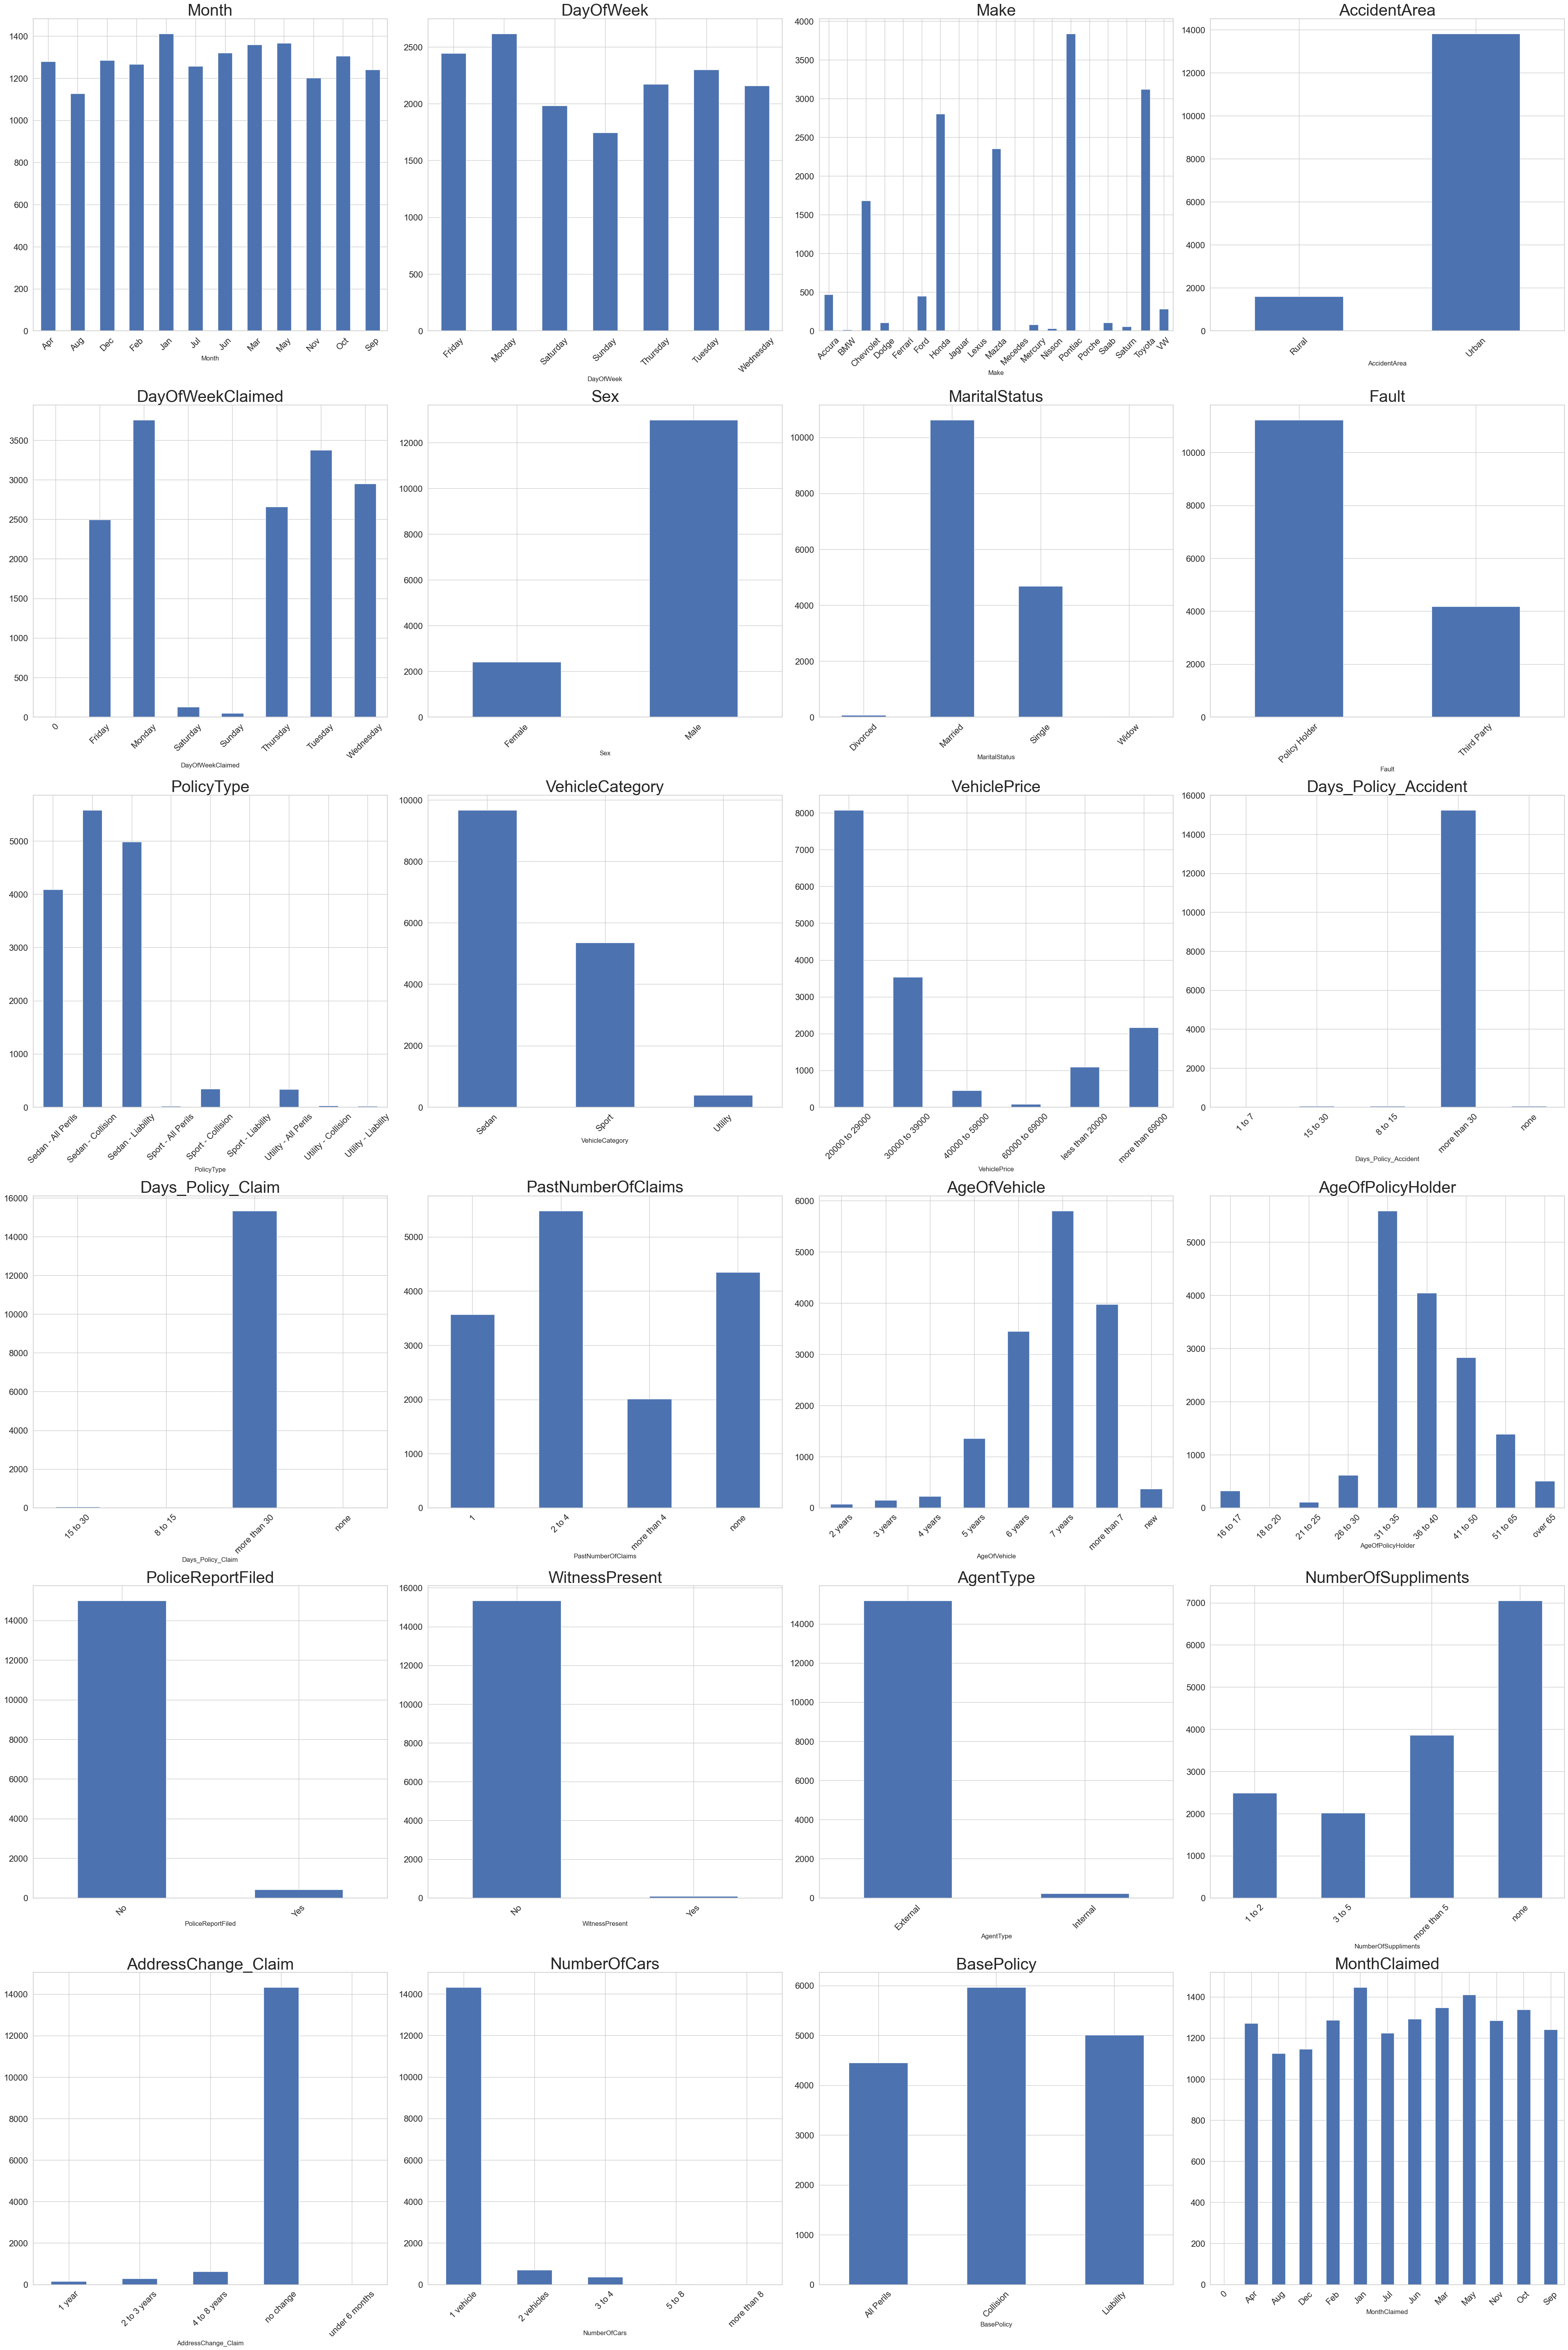

In [19]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(6, 4, figsize=(40,60), constrained_layout=True)
for i in range(6):
    for j in range(4):
        if 4*i + j < len(cat_features):
            df[cat_features[4*i + j]].value_counts().sort_index().plot.bar(ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].tick_params(labelsize=16)
            ax[i, j].set_title(cat_features[4*i + j], size=30)

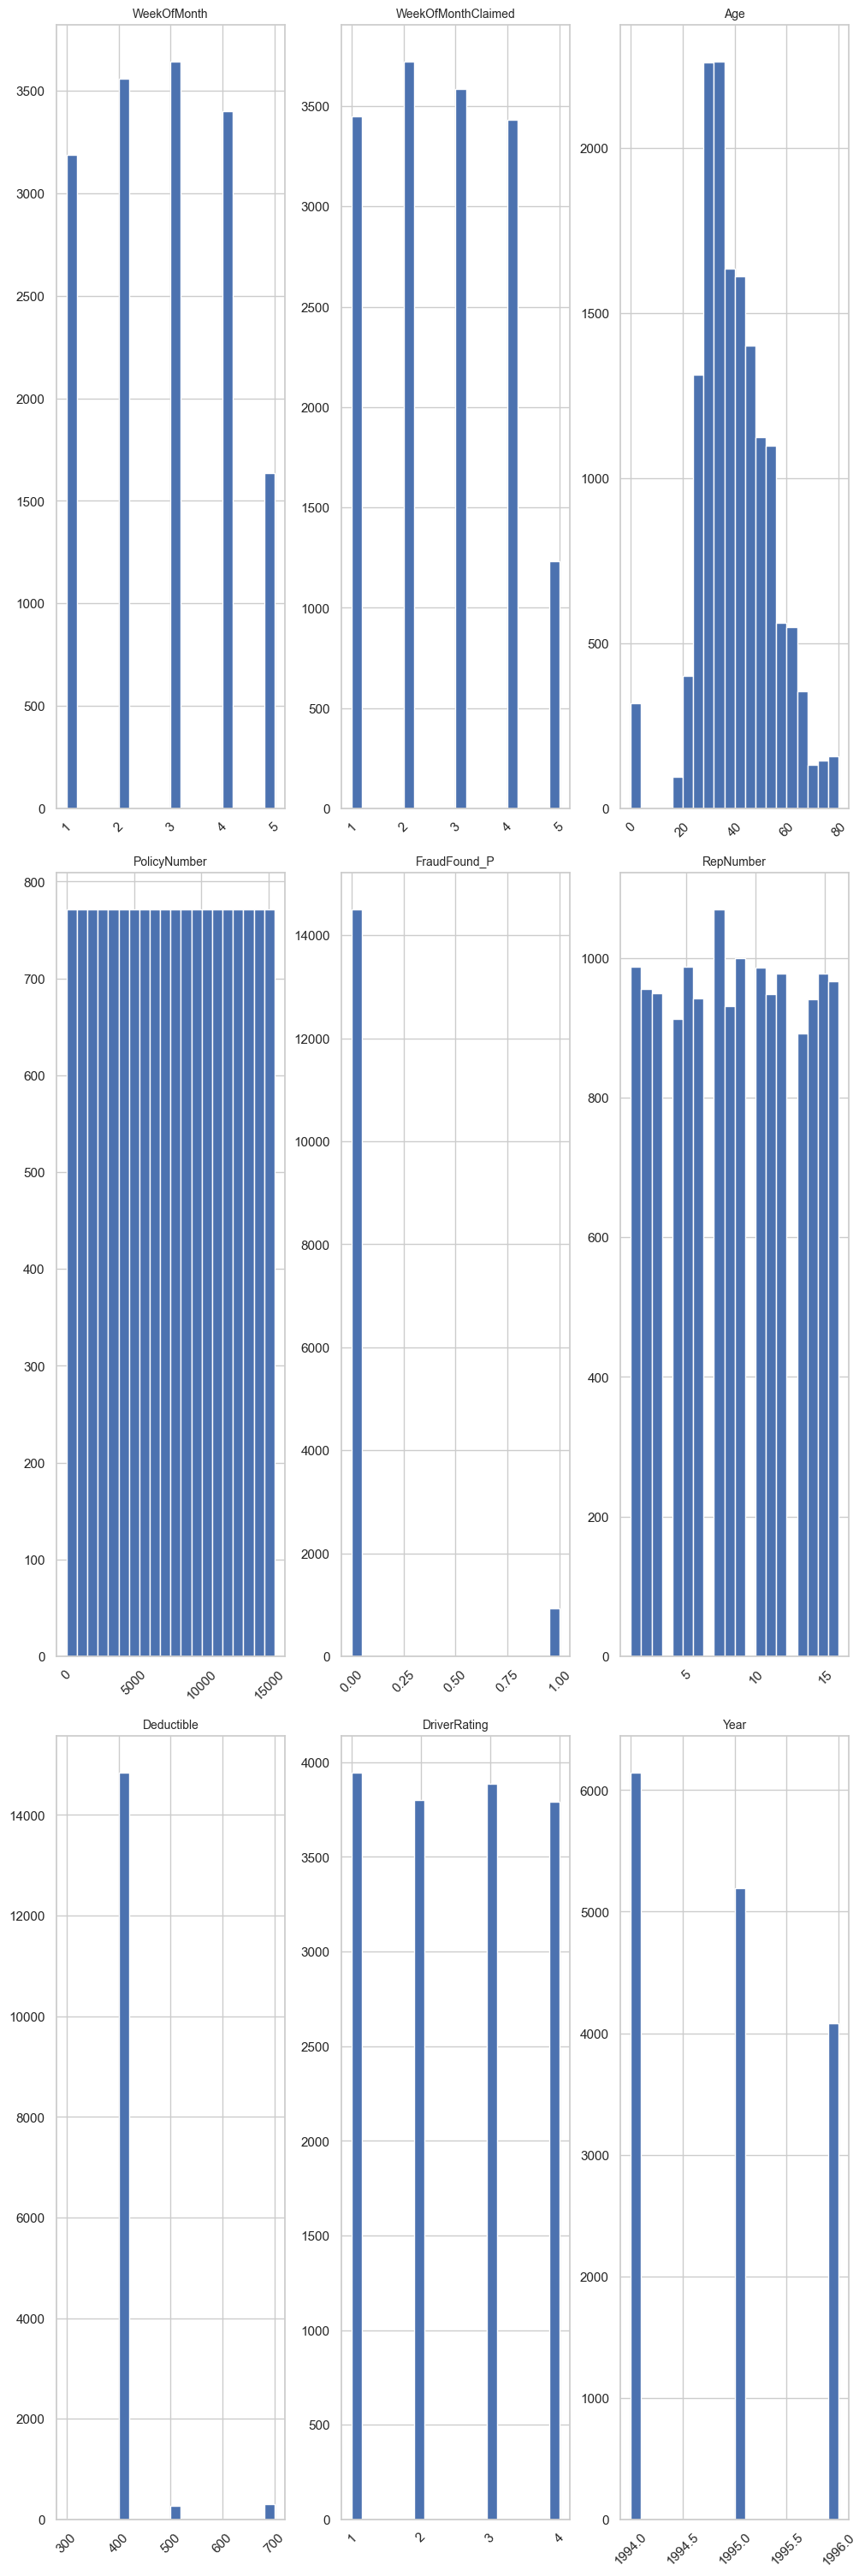

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(10,30), constrained_layout=True)
for i in range(3):
    for j in range(3):
        if 2*i + j < len(num_features):
            df[num_features[3*i + j]].hist(bins=20, ax=ax[i, j])
            ax[i, j].tick_params('x', rotation=45)
            ax[i, j].set_title(num_features[3*i + j],size=10)

/var/folders/y0/rgr2l6md3fn37h8vzc_vdb2h0000gn/T/ipykernel_13276/3954620974.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");


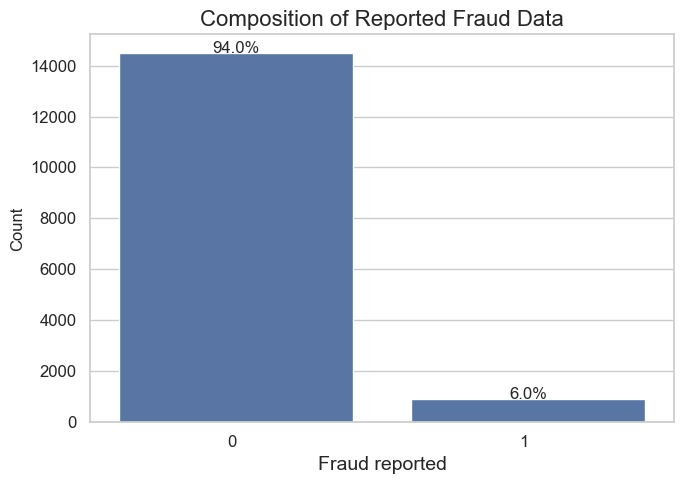

In [21]:
plt.figure(figsize =(7,5))
ax = sns.countplot(data = df, x = 'FraudFound_P')
plt.xticks(size = 12)
plt.xlabel('Fraud reported', size = 14)
plt.yticks(size = 12)
plt.ylabel('Count', size = 12)
plt.title("Composition of Reported Fraud Data", size = 16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.tight_layout()
plt.show()

# Pre-Pipeline

In [22]:
df=df.replace({"?": np.nan})
df['FraudFound_P'] = df['FraudFound_P'].replace({'No': 0})
df['FraudFound_P'] = df['FraudFound_P'].replace({'Yes': 1})
pd.set_option('display.max_columns', None)
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

   PolicyNumber  RepNumber  Deductible  DriverRating Days_Policy_Accident  \
0             1         12         300             1         more than 30   
1             2         15         400             4         more than 30   
2             3          7         400             3         more than 30   
3             4          4         400             2         more than 30   
4             5          3         400             1         more than 30   

  Days_Policy_Claim PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder  \
0      more than 30               none      3 years          26 to 30   
1      more than 30               none      6 years          31 to 35   
2      more than 30                  1      7 years          41 to 50   
3      more than 30                  1  more than 7          51 to 65   
4      more than 30               none      5 years          31 to 35   

  PoliceReportFiled WitnessPresent AgentType NumberOfSuppliments  \
0                No             No  External                none   
1               Yes             No  External                none   
2                No             No  External                none   
3               Yes             No  External         more than 5   
4                No             No  External                none   

  AddressChange_Claim NumberOfCars  Year BasePolicy  
0              1 year       3 to 4  1994  Liability  
1           no change    1 vehicle  1994  Collision  
2           no change    1 vehicle  1994  Collision  
3           no change    1 vehicle  1994  Liability  
4           no change    1 vehicle  1994  Collision

In [23]:
#Features & Label Setting
data = df.drop(columns=['FraudFound_P'])
label = df[['FraudFound_P']]
feature_names = data.columns

In [24]:
x_train, x_test, y_train, y_test = train_test_split(data,label, train_size=0.8, random_state=1)

In [25]:
# Define preprocessor for one-hot encoding and min-max scaling

cat_col = ['Month','DayOfWeek','Make','AccidentArea',
                    'DayOfWeekClaimed','Sex','MaritalStatus',
                    'Fault','PolicyType','VehicleCategory',
                    'VehiclePrice','Days_Policy_Accident',
                    'Days_Policy_Claim','PastNumberOfClaims','AgeOfVehicle',
                    'AgeOfPolicyHolder','PoliceReportFiled','WitnessPresent',
                    'AgentType','NumberOfSuppliments','AddressChange_Claim',
                    'NumberOfCars','BasePolicy','MonthClaimed']

num_col = ['WeekOfMonth','WeekOfMonthClaimed','Age',
           'PolicyNumber','RepNumber','Deductible',
           'DriverRating','Year']

### Transformers for numerical data
numerical_transformer = Pipeline(steps=[('Scaler', MinMaxScaler())])

### Transformers for categorical data
categorical_transformer = Pipeline(steps=[('Encoder', OneHotEncoder(handle_unknown='ignore'))])

### Combine pipelines using ColumnTransformer
preprocessing = ColumnTransformer(transformers=[('Numerical', numerical_transformer, num_col),
                                                ('Categorical', categorical_transformer, cat_col)],
                                  remainder='passthrough')

# PIPELINE
- Decision Tree
- Random Forest
- XGBoost
- Approximating XGBoost

## DECISION TREE

### Model

In [26]:
param_dt = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

# Create pipelines with SMOTE for each model (nested GridSearchCV)
dt_grid = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid=param_dt, scoring='roc_auc', cv=5)

dt_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', dt_grid)
])

dt_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['WeekOfMonth',
                                                   'WeekOfMonthClaimed', 'Age',
                                                   'PolicyNumber', 'RepNumber',
                                                   'Deductible', 'DriverRating',
                                                   'Year']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayO...
                                                   'NumberOfCars', 'BasePolicy',
                                                   'MonthClaimed'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=DecisionTreeClassifier(criterion='entropy'),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [27]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = dt_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': np.int64(9), 'min_samples_leaf': 50, 'min_samples_split': 100}


In [28]:
pd.DataFrame(dt_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
401       0.260806      0.008043         0.006194        0.000528   
400       0.260637      0.013276         0.005623        0.000497   
402       0.258227      0.011706         0.005808        0.000358   
403       0.256784      0.010151         0.005645        0.000327   
404       0.249458      0.009635         0.005836        0.000440   
..             ...           ...              ...             ...   
93        0.149433      0.002548         0.005995        0.001044   
91        0.148136      0.001772         0.005388        0.000417   
90        0.147402      0.001532         0.005256        0.000202   
94        0.147156      0.001886         0.005292        0.000235   
95        0.147079      0.001475         0.005264        0.000261   

     param_max_depth  param_min_samples_leaf  param_min_samples_split  \
401                9                      50                      100   
400                9                      50                       50   
402                9                      50                      150   
403                9                      50                      200   
404                9                      50                      250   
..               ...                     ...                      ...   
93                 5                     500                      200   
91                 5                     500                      100   
90                 5                     500                       50   
94                 5                     500                      250   
95                 5                     500                      300   

                                                params  split0_test_score  \
401  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.907781   
400  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.907781   
402  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.908400   
403  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.906515   
404  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.907859   
..                                                 ...                ...   
93   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.831431   
91   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.831431   
90   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.831431   
94   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.831431   
95   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.831431   

     split1_test_score  split2_test_score  split3_test_score  \
401           0.967136           0.967759           0.969283   
400           0.967136           0.967759           0.969131   
402           0.964718           0.966749           0.968796   
403           0.963871           0.965770           0.968534   
404           0.963183           0.964118           0.966303   
..                 ...                ...                ...   
93            0.872402           0.858578           0.860625   
91            0.872402           0.858578           0.860625   
90            0.872402           0.858578           0.860625   
94            0.872402           0.858578           0.860625   
95            0.872402           0.858578           0.860625   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
401           0.970542         0.956500        0.024388                1  
400           0.970542         0.956470        0.024373                2  
402           0.970304         0.955793        0.023772                3  
403           0.969843         0.954907        0.024285                4  
404           0.969002         0.954093        0.023204                5  
..                 ...              ...             ...              ...  
93            0.867022         0.858012        0.014156              491  
91   

In [29]:
joblib.dump(dt_pipeline, 'model_dt15.h5')

['model_dt15.h5']

### Statistical Performances

In [30]:
train_dt = dt_pipeline.predict(x_test)
print(classification_report(y_test, train_dt))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2879
           1       0.14      0.15      0.15       205

    accuracy                           0.88      3084
   macro avg       0.54      0.54      0.54      3084
weighted avg       0.89      0.88      0.89      3084



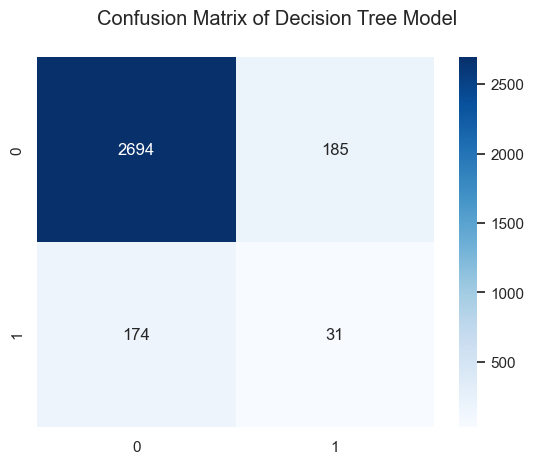

In [31]:
cm = confusion_matrix(y_test, train_dt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Decision Tree Model")
plt.show()

In [32]:
# Calculate ROC AUC
probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.763549335389151
Specificity: 0.9357415769364362
Sensitivity: 0.15121951219512195


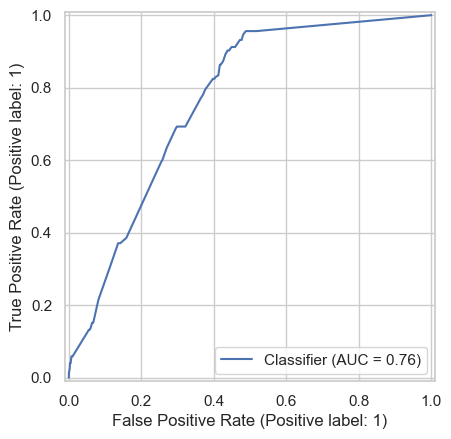

In [33]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [34]:
model_dt = DecisionTreeClassifier(criterion='entropy', **dt_pipeline.named_steps['grid_search'].best_params_)

In [35]:
dt_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_dt)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    dt_pipeline.fit(x_train, y_train)

    train_dt = dt_pipeline.predict(x_test)

    # Calculate ROC AUC
    probabilities = dt_pipeline.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_dt)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.767725073916248
Specificity = 0.9357415769364362
Sensitivity = 0.15121951219512195
 
iteration2
ROC_AUC = 0.7648243377188895
Specificity = 0.9357415769364362
Sensitivity = 0.15121951219512195
 
iteration3
ROC_AUC = 0.767725073916248
Specificity = 0.9357415769364362
Sensitivity = 0.15121951219512195
 
iteration4
ROC_AUC = 0.7648243377188895
Specificity = 0.9357415769364362
Sensitivity = 0.15121951219512195
 
iteration5
ROC_AUC = 0.7677835291725617
Specificity = 0.9357415769364362
Sensitivity = 0.15121951219512195
 


## RANDOM FOREST

### Model

In [36]:
param_rf = {'max_depth': np.arange(5, 10),
            'min_samples_leaf': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            'min_samples_split': (50, 100, 150, 200, 250, 300, 350, 400, 450, 500)}

rf_grid = GridSearchCV(RandomForestClassifier(n_estimators=250,
                                              criterion='entropy',
                                              n_jobs=-1),
                       param_grid=param_rf, scoring='roc_auc',cv=5)

rf_pipeline = ImbPipeline([
    ('preprocessing', preprocessing),
    ('oversampling', SMOTE(random_state=1)),
    ('grid_search', rf_grid)
])

rf_pipeline.fit(x_train, y_train)

/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was exp

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['WeekOfMonth',
                                                   'WeekOfMonthClaimed', 'Age',
                                                   'PolicyNumber', 'RepNumber',
                                                   'Deductible', 'DriverRating',
                                                   'Year']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayO...
                                                   'MonthClaimed'])])),
                ('oversampling', SMOTE(random_state=1)),
                ('grid_search',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(criterion='entropy',
                                                               n_estimators=250,
                                                               n_jobs=-1),
                              param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                                          'min_samples_leaf': (50, 100, 150,
                                                               200, 250, 300,
                                                               350, 400, 450,
                                                               500),
                                          'min_samples_split': (50, 100, 150,
                                                                200, 250, 300,
                                                                350, 400, 450,
                                                                500)},
                              scoring='roc_auc'))])

In [37]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = rf_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': np.int64(9), 'min_samples_leaf': 50, 'min_samples_split': 50}


In [38]:
pd.DataFrame(rf_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
400       2.331197      0.023373         0.077723        0.005914   
401       2.375482      0.036910         0.075394        0.002177   
402       2.301187      0.050824         0.091943        0.032097   
403       2.215732      0.069684         0.075200        0.005105   
404       2.181782      0.042246         0.068669        0.004304   
..             ...           ...              ...             ...   
93        0.853721      0.020791         0.065652        0.011440   
95        0.815378      0.020184         0.066882        0.001399   
90        0.839310      0.016810         0.062121        0.005359   
96        0.832309      0.024178         0.066539        0.008558   
91        0.823165      0.033271         0.066101        0.005744   

     param_max_depth  param_min_samples_leaf  param_min_samples_split  \
400                9                      50                       50   
401                9                      50                      100   
402                9                      50                      150   
403                9                      50                      200   
404                9                      50                      250   
..               ...                     ...                      ...   
93                 5                     500                      200   
95                 5                     500                      300   
90                 5                     500                       50   
96                 5                     500                      350   
91                 5                     500                      100   

                                                params  split0_test_score  \
400  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.936596   
401  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.937461   
402  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.935685   
403  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.933425   
404  {'max_depth': 9, 'min_samples_leaf': 50, 'min_...           0.931523   
..                                                 ...                ...   
93   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.890237   
95   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.891913   
90   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.890279   
96   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.892468   
91   {'max_depth': 5, 'min_samples_leaf': 500, 'min...           0.891811   

     split1_test_score  split2_test_score  split3_test_score  \
400           0.982962           0.979406           0.980307   
401           0.982588           0.978039           0.979879   
402           0.981077           0.976606           0.980610   
403           0.980000           0.977683           0.979297   
404           0.980277           0.976096           0.976955   
..                 ...                ...                ...   
93            0.939006           0.935573           0.936375   
95            0.942862           0.935295           0.935098   
90            0.939239           0.935359           0.936882   
96            0.944862           0.929016           0.932679   
91            0.937837           0.927631           0.939289   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
400           0.983668         0.972588        0.018066                1  
401           0.982736         0.972141        0.017428                2  
402           0.981296         0.971055        0.017768                3  
403           0.980318         0.970145        0.018382                4  
404           0.980665         0.969103        0.018875                5  
..                 ...              ...             ...              ...  
93            0.946681         0.929574        0.020056              496  
95   

In [39]:
joblib.dump(rf_pipeline, 'model_rf15.h5')

['model_rf15.h5']

### Statistical Performances

In [40]:
train_rf = rf_pipeline.predict(x_test)
print(classification_report(y_test, train_rf))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2879
           1       0.17      0.54      0.26       205

    accuracy                           0.79      3084
   macro avg       0.56      0.68      0.57      3084
weighted avg       0.91      0.79      0.84      3084



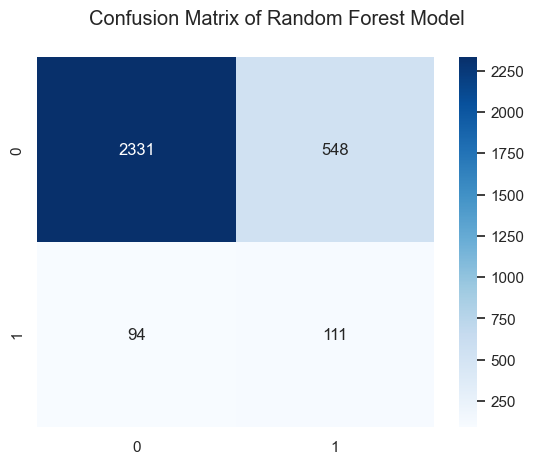

In [41]:
cm = confusion_matrix(y_test, train_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of Random Forest Model")
plt.show()

In [42]:
# Calculate ROC AUC
probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.8042104728098339
Specificity: 0.8096561306009031
Sensitivity: 0.5414634146341464


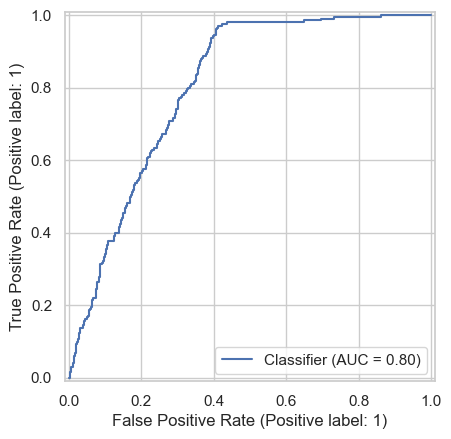

In [43]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [44]:
model_rf = RandomForestClassifier(n_estimators=250, criterion='entropy',
                                 **rf_pipeline.named_steps['grid_search'].best_params_)

rf_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_rf)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    rf_pipeline.fit(x_train, y_train)

    train_rf = rf_pipeline.predict(x_test)

    # Calculate ROC AUC
    probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_rf)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iteration1
ROC_AUC = 0.8011284406001405
Specificity = 0.8103508162556443
Sensitivity = 0.526829268292683
 


/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iteration2
ROC_AUC = 0.7968434161590661
Specificity = 0.8186870441125391
Sensitivity = 0.47804878048780486
 


/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iteration3
ROC_AUC = 0.7973449453146841
Specificity = 0.8096561306009031
Sensitivity = 0.5073170731707317
 


/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iteration4
ROC_AUC = 0.8009505332983167
Specificity = 0.8100034734282737
Sensitivity = 0.5121951219512195
 


/Users/adlir/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


iteration5
ROC_AUC = 0.7957251416904582
Specificity = 0.7999305314345259
Sensitivity = 0.5170731707317073
 


## XGBOOST

### Model

In [45]:
param_xgb_main = {'max_depth': np.arange(5, 10),
                  'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                  'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
                  'n_estimators': [100, 200, 300, 400, 500],
                  'lambda': np.arange(0, 10),
                  'gamma': np.arange(0, 10),
                  'colsample_bytree':np.arange(0.5, 1),
                  'min_child_weight':np.arange(4, 10)}

In [46]:
param_xgb = {'max_depth': np.arange(5, 10),
             'eta': [0.01, 0.05, 0.10, 0.15, 0.20],
             'gamma': np.arange(0, 10),
             'lambda': np.arange(0, 10)}

xgb_grid = GridSearchCV(XGBClassifier(n_estimators=250,
                                      subsample=0.8,
                                      objective='binary:logistic',
                                      eval_metric='logloss'),
                        param_grid=param_xgb, cv=5, scoring ='roc_auc', n_jobs=-1)

xgb_pipeline = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('grid_search', xgb_grid)])

xgb_pipeline.fit(x_train, y_train)

/Users/adlir/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Numerical',
                                                  Pipeline(steps=[('Scaler',
                                                                   MinMaxScaler())]),
                                                  ['WeekOfMonth',
                                                   'WeekOfMonthClaimed', 'Age',
                                                   'PolicyNumber', 'RepNumber',
                                                   'Deductible', 'DriverRating',
                                                   'Year']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Month', 'DayO...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=250,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                                          'gamma': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'lambda': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                          'max_depth': array([5, 6, 7, 8, 9])},
                              scoring='roc_auc'))])

In [47]:
# Mengakses hyperparameter terbaik dari GridSearchCV
best_params = xgb_pipeline.named_steps['grid_search'].best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'eta': 0.2, 'gamma': np.int64(0), 'lambda': np.int64(7), 'max_depth': np.int64(9)}


In [48]:
pd.DataFrame(xgb_pipeline.named_steps['grid_search'].cv_results_).sort_values("rank_test_score", ascending=True)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_eta  \
2039      13.645683      4.314044         0.250011        0.038153       0.20   
1528      12.058075      3.528663         0.268842        0.025644       0.15   
1039      16.625661      4.038889         0.308219        0.040117       0.10   
2044      16.106085      4.882872         0.278746        0.031456       0.20   
1533      12.257623      3.538070         0.253916        0.042839       0.15   
...             ...           ...              ...             ...        ...   
35        10.588340      0.198296         0.254645        0.022344       0.01   
295       10.231876      0.064329         0.259135        0.019606       0.01   
245       10.243824      0.112416         0.201622        0.033635       0.01   
145       10.133972      0.118782         0.227911        0.010802       0.01   
195       10.161634      0.051556         0.248648        0.012570       0.01   

      param_gamma  param_lambda  param_max_depth  \
2039            0             7                9   
1528            0             5                8   
1039            0             7                9   
2044            0             8                9   
1533            0             6                8   
...           ...           ...              ...   
35              0             7                5   
295             5             9                5   
245             4             9                5   
145             2             9                5   
195             3             9                5   

                                                 params  split0_test_score  \
2039  {'eta': 0.2, 'gamma': 0, 'lambda': 7, 'max_dep...           0.950658   
1528  {'eta': 0.15, 'gamma': 0, 'lambda': 5, 'max_de...           0.950494   
1039  {'eta': 0.1, 'gamma': 0, 'lambda': 7, 'max_dep...           0.950307   
2044  {'eta': 0.2, 'gamma': 0, 'lambda': 8, 'max_dep...           0.950237   
1533  {'eta': 0.15, 'gamma': 0, 'lambda': 6, 'max_de...           0.950164   
...                                                 ...                ...   
35    {'eta': 0.01, 'gamma': 0, 'lambda': 7, 'max_de...           0.927784   
295   {'eta': 0.01, 'gamma': 5, 'lambda': 9, 'max_de...           0.927798   
245   {'eta': 0.01, 'gamma': 4, 'lambda': 9, 'max_de...           0.927798   
145   {'eta': 0.01, 'gamma': 2, 'lambda': 9, 'max_de...           0.927791   
195   {'eta': 0.01, 'gamma': 3, 'lambda': 9, 'max_de...           0.927791   

      split1_test_score  split2_test_score  split3_test_score  \
2039           1.000000           1.000000           1.000000   
1528           1.000000           1.000000           1.000000   
1039           1.000000           1.000000           1.000000   
2044           1.000000           1.000000           1.000000   
1533           1.000000           1.000000           1.000000   
...                 ...                ...                ...   
35             0.999143           0.999679           0.999401   
295            0.999152           0.999668           0.999357   
245            0.999152           0.999668           0.999357   
145            0.999169           0.999667           0.999345   
195            0.999133           0.999668           0.999343   

      split4_test_score  mean_test_score  std_test_score  rank_test_score  
2039           1.000000         0.990132        0.019737                1  
1528           1.000000         0.990099        0.019802                2  
1039           1.000000         0.990061        0.019877                3  
2044           1.000000         0.990047        0.019905                4  
1533           1.000000         0.990033        0.019934                5  
...                 ...              ...             ...              ...  
35             0.999291         0.985060        0.028638             2496  
295            0.999290         0.985053        0.028628             2497  
245   

In [49]:
joblib.dump(xgb_pipeline, 'model_xgb15.h5')

['model_xgb15.h5']

### Statistical Performances

In [50]:
train_xgb = xgb_pipeline.predict(x_test)
print(classification_report(y_test, train_xgb))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2879
           1       0.82      0.22      0.35       205

    accuracy                           0.95      3084
   macro avg       0.88      0.61      0.66      3084
weighted avg       0.94      0.95      0.93      3084



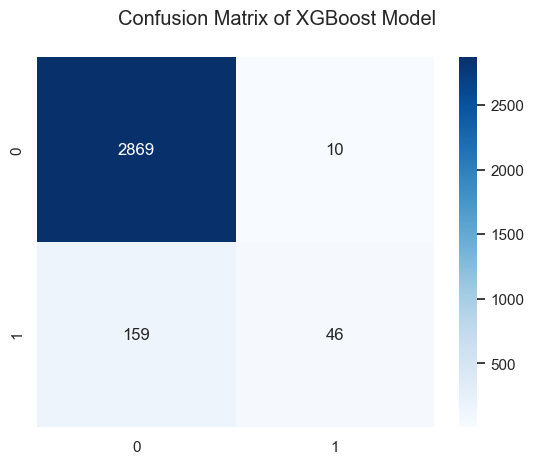

In [51]:
cm = confusion_matrix(y_test, train_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix of XGBoost Model")
plt.show()

In [52]:
# Calculate ROC AUC
probabilities = xgb_pipeline.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.9592270351324562
Specificity: 0.9965265717262939
Sensitivity: 0.22439024390243903


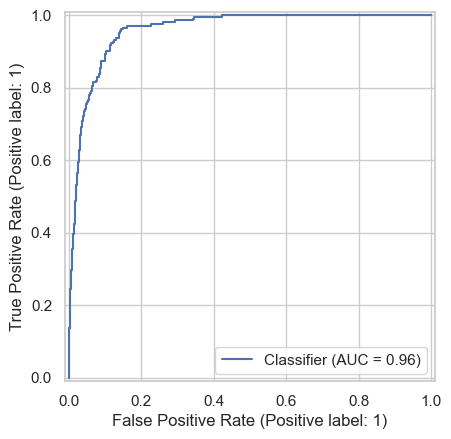

In [53]:
RocCurveDisplay.from_predictions(y_test, probabilities, pos_label=1)
plt.show()

In [54]:
model_xgb = XGBClassifier(n_estimators=250,
                          subsample=0.8,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          **xgb_pipeline.named_steps['grid_search'].best_params_)

In [55]:
# model_xgb = XGBClassifier(n_estimators=250,
#                           subsample=0.8,
#                           objective='binary:logistic',
#                           eval_metric='logloss',
#                           eta=0.2, gamma=0, reg_lambda=8, max_depth=8)

In [56]:
xgb_pipelines = ImbPipeline([('preprocessing', preprocessing),
                            ('oversampling', SMOTE(random_state=1)),
                            ('model', model_xgb)])

roc_auc = []
specificity = []
sensitivity = []

for i in range(5):
    xgb_pipelines.fit(x_train, y_train)

    train_xgb = xgb_pipelines.predict(x_test)

    # Calculate ROC AUC
    probabilities = xgb_pipelines.predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    cm = confusion_matrix(y_test, train_xgb)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"iteration{i+1}")
    print(f"ROC_AUC = {roc_auc}")
    print(f"Specificity = {specificity}")
    print(f"Sensitivity = {sensitivity}")
    print(" ")

iteration1
ROC_AUC = 0.9592270351324562
Specificity = 0.9965265717262939
Sensitivity = 0.22439024390243903
 
iteration2
ROC_AUC = 0.9592270351324562
Specificity = 0.9965265717262939
Sensitivity = 0.22439024390243903
 
iteration3
ROC_AUC = 0.9592270351324562
Specificity = 0.9965265717262939
Sensitivity = 0.22439024390243903
 
iteration4
ROC_AUC = 0.9592270351324562
Specificity = 0.9965265717262939
Sensitivity = 0.22439024390243903
 
iteration5
ROC_AUC = 0.9592270351324562
Specificity = 0.9965265717262939
Sensitivity = 0.22439024390243903
 


## APPROXIMATING XGBOOST

### Pre-Modeling

In [57]:
#one-hot encode categorical data
encoder = OneHotEncoder(sparse_output=False)
df_encoded = pd.DataFrame(encoder.fit_transform(data[cat_col]))
df_encoded.columns = encoder.get_feature_names_out(cat_col)

#scale numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[num_col])
df_scaled = pd.DataFrame(scaled_data, columns=num_col)

df_preprocessed = pd.concat([df_encoded, df_scaled], axis=1)
df_preprocessed

Month_Apr  Month_Aug  Month_Dec  Month_Feb  Month_Jan  Month_Jul  \
0            0.0        0.0        1.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        1.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        1.0        0.0   
...          ...        ...        ...        ...        ...        ...   
15415        0.0        0.0        0.0        0.0        0.0        0.0   
15416        0.0        0.0        0.0        0.0        0.0        0.0   
15417        0.0        0.0        0.0        0.0        0.0        0.0   
15418        0.0        0.0        1.0        0.0        0.0        0.0   
15419        0.0        0.0        1.0        0.0        0.0        0.0   

       Month_Jun  Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        1.0        0.0   
3            1.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
15415        0.0        0.0        0.0        1.0        0.0        0.0   
15416        0.0        0.0        0.0        1.0        0.0        0.0   
15417        0.0        0.0        0.0        1.0        0.0        0.0   
15418        0.0        0.0        0.0        0.0        0.0        0.0   
15419        0.0        0.0        0.0        0.0        0.0        0.0   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
0                   0.0               0.0                 0.0   
1                   0.0               0.0                 0.0   
2                   1.0               0.0                 0.0   
3                   0.0               0.0                 1.0   
4                   0.0               1.0                 0.0   
...                 ...               ...                 ...   
15415               1.0               0.0                 0.0   
15416               0.0               0.0                 0.0   
15417               0.0               0.0                 0.0   
15418               0.0               1.0                 0.0   
15419               0.0               0.0                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday  \
0                   0.0                 0.0                0.0   
1                   0.0                 0.0                0.0   
2                   0.0                 0.0                0.0   
3                   0.0                 0.0                0.0   
4                   0.0                 0.0                0.0   
...                 ...                 ...                ...   
15415               0.0                 0.0                0.0   
15416               0.0                 1.0                0.0   
15417               0.0                 1.0                0.0   
15418               0.0                 0.0                0.0   
15419               0.0                 0.0                0.0   

       DayOfWeek_Wednesday  Make_Accura  Make_BMW  Make_Chevrolet  Make_Dodge  \
0                      1.0          0.0       0.0             0.0         0.0   
1                      1.0          0.0       0.0             0.0         0.0   
2                      0.0          0.0       0.0             0.0         0.0   
3                      0.0          0.0       0.0             0.0         0.0   
4                      0.0          0.0       0.0             0.0         0.0   
...                    ...          ...       ...             ...         ...   
15415                  0.0          0.0       0.0             0.

In [58]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_preprocessed, label, train_size=0.8, random_state=1)

In [59]:
# Create SMOTE object
smote = SMOTE(random_state=1)

# Transform data
x_smote, y_smote = smote.fit_resample(x_train2, y_train2)

In [60]:
x_smote

Month_Apr  Month_Aug  Month_Dec  Month_Feb  Month_Jan  Month_Jul  \
0       1.000000   0.000000   0.000000        0.0   0.000000        0.0   
1       0.000000   0.000000   0.000000        0.0   0.000000        0.0   
2       0.000000   0.000000   0.000000        0.0   0.000000        0.0   
3       0.000000   0.000000   0.000000        1.0   0.000000        0.0   
4       1.000000   0.000000   0.000000        0.0   0.000000        0.0   
...          ...        ...        ...        ...        ...        ...   
23231   0.000000   0.000000   0.000000        0.0   0.821023        0.0   
23232   0.000000   0.000000   0.000000        0.0   1.000000        0.0   
23233   0.830195   0.000000   0.000000        0.0   0.169805        0.0   
23234   0.000000   0.276012   0.723988        0.0   0.000000        0.0   
23235   0.000000   0.000000   0.000000        0.0   1.000000        0.0   

       Month_Jun  Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
0       0.000000        0.0        0.0        0.0        0.0        0.0   
1       0.000000        1.0        0.0        0.0        0.0        0.0   
2       0.000000        0.0        0.0        0.0        1.0        0.0   
3       0.000000        0.0        0.0        0.0        0.0        0.0   
4       0.000000        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
23231   0.178977        0.0        0.0        0.0        0.0        0.0   
23232   0.000000        0.0        0.0        0.0        0.0        0.0   
23233   0.000000        0.0        0.0        0.0        0.0        0.0   
23234   0.000000        0.0        0.0        0.0        0.0        0.0   
23235   0.000000        0.0        0.0        0.0        0.0        0.0   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
0              0.000000          0.000000                 0.0   
1              0.000000          1.000000                 0.0   
2              0.000000          0.000000                 1.0   
3              0.000000          0.000000                 1.0   
4              0.000000          0.000000                 0.0   
...                 ...               ...                 ...   
23231          0.178977          0.000000                 0.0   
23232          0.000000          0.499183                 0.0   
23233          0.000000          0.169805                 0.0   
23234          0.000000          0.000000                 0.0   
23235          0.160025          0.000000                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday  \
0              1.000000            0.000000                0.0   
1              0.000000            0.000000                0.0   
2              0.000000            0.000000                0.0   
3              0.000000            0.000000                0.0   
4              0.000000            0.000000                0.0   
...                 ...                 ...                ...   
23231          0.000000            0.821023                0.0   
23232          0.000000            0.500817                0.0   
23233          0.830195            0.000000                0.0   
23234          1.000000            0.000000                0.0   
23235          0.000000            0.000000                0.0   

       DayOfWeek_Wednesday  Make_Accura  Make_BMW  Make_Chevrolet  Make_Dodge  \
0                 0.000000          0.0       0.0        0.000000         0.0   
1                 0.000000          0.0       0.0        0.000000         0.0   
2                 0.000000          0.0       0.0        0.000000         0.0   
3                 0.000000          0.0       0.0        0.000000         0.0   
4                 1.000000          0.0       0.0        0.000000         0.0   
...                    ...          ...       ...             ...         ...   
23231             0.000000          0.0       0.0        0.17897

In [61]:
x_smote.columns = [str(col) for col in x_smote.columns]
x_smote

Month_Apr  Month_Aug  Month_Dec  Month_Feb  Month_Jan  Month_Jul  \
0       1.000000   0.000000   0.000000        0.0   0.000000        0.0   
1       0.000000   0.000000   0.000000        0.0   0.000000        0.0   
2       0.000000   0.000000   0.000000        0.0   0.000000        0.0   
3       0.000000   0.000000   0.000000        1.0   0.000000        0.0   
4       1.000000   0.000000   0.000000        0.0   0.000000        0.0   
...          ...        ...        ...        ...        ...        ...   
23231   0.000000   0.000000   0.000000        0.0   0.821023        0.0   
23232   0.000000   0.000000   0.000000        0.0   1.000000        0.0   
23233   0.830195   0.000000   0.000000        0.0   0.169805        0.0   
23234   0.000000   0.276012   0.723988        0.0   0.000000        0.0   
23235   0.000000   0.000000   0.000000        0.0   1.000000        0.0   

       Month_Jun  Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
0       0.000000        0.0        0.0        0.0        0.0        0.0   
1       0.000000        1.0        0.0        0.0        0.0        0.0   
2       0.000000        0.0        0.0        0.0        1.0        0.0   
3       0.000000        0.0        0.0        0.0        0.0        0.0   
4       0.000000        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
23231   0.178977        0.0        0.0        0.0        0.0        0.0   
23232   0.000000        0.0        0.0        0.0        0.0        0.0   
23233   0.000000        0.0        0.0        0.0        0.0        0.0   
23234   0.000000        0.0        0.0        0.0        0.0        0.0   
23235   0.000000        0.0        0.0        0.0        0.0        0.0   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
0              0.000000          0.000000                 0.0   
1              0.000000          1.000000                 0.0   
2              0.000000          0.000000                 1.0   
3              0.000000          0.000000                 1.0   
4              0.000000          0.000000                 0.0   
...                 ...               ...                 ...   
23231          0.178977          0.000000                 0.0   
23232          0.000000          0.499183                 0.0   
23233          0.000000          0.169805                 0.0   
23234          0.000000          0.000000                 0.0   
23235          0.160025          0.000000                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday  \
0              1.000000            0.000000                0.0   
1              0.000000            0.000000                0.0   
2              0.000000            0.000000                0.0   
3              0.000000            0.000000                0.0   
4              0.000000            0.000000                0.0   
...                 ...                 ...                ...   
23231          0.000000            0.821023                0.0   
23232          0.000000            0.500817                0.0   
23233          0.830195            0.000000                0.0   
23234          1.000000            0.000000                0.0   
23235          0.000000            0.000000                0.0   

       DayOfWeek_Wednesday  Make_Accura  Make_BMW  Make_Chevrolet  Make_Dodge  \
0                 0.000000          0.0       0.0        0.000000         0.0   
1                 0.000000          0.0       0.0        0.000000         0.0   
2                 0.000000          0.0       0.0        0.000000         0.0   
3                 0.000000          0.0       0.0        0.000000         0.0   
4                 1.000000          0.0       0.0        0.000000         0.0   
...                    ...          ...       ...             ...         ...   
23231             0.000000          0.0       0.0        0.17897

In [62]:
x_smote.columns

Index(['Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
       'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov',
       ...
       'MonthClaimed_Oct', 'MonthClaimed_Sep', 'WeekOfMonth',
       'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Year'],
      dtype='object', length=148)

In [63]:
y_smote

FraudFound_P
0                 0
1                 0
2                 0
3                 0
4                 1
...             ...
23231             1
23232             1
23233             1
23234             1
23235             1

[23236 rows x 1 columns]

In [64]:
x_test2

Month_Apr  Month_Aug  Month_Dec  Month_Feb  Month_Jan  Month_Jul  \
2951         0.0        0.0        0.0        0.0        0.0        0.0   
15151        0.0        0.0        0.0        0.0        0.0        1.0   
10830        0.0        0.0        0.0        0.0        1.0        0.0   
15271        0.0        0.0        0.0        0.0        0.0        0.0   
2141         0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
6619         0.0        0.0        0.0        0.0        0.0        0.0   
81           0.0        0.0        0.0        0.0        1.0        0.0   
1404         0.0        0.0        1.0        0.0        0.0        0.0   
7200         0.0        0.0        0.0        0.0        0.0        0.0   
2506         0.0        1.0        0.0        0.0        0.0        0.0   

       Month_Jun  Month_Mar  Month_May  Month_Nov  Month_Oct  Month_Sep  \
2951         0.0        1.0        0.0        0.0        0.0        0.0   
15151        0.0        0.0        0.0        0.0        0.0        0.0   
10830        0.0        0.0        0.0        0.0        0.0        0.0   
15271        1.0        0.0        0.0        0.0        0.0        0.0   
2141         0.0        1.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
6619         0.0        0.0        1.0        0.0        0.0        0.0   
81           0.0        0.0        0.0        0.0        0.0        0.0   
1404         0.0        0.0        0.0        0.0        0.0        0.0   
7200         0.0        0.0        0.0        0.0        0.0        1.0   
2506         0.0        0.0        0.0        0.0        0.0        0.0   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
2951                0.0               0.0                 0.0   
15151               0.0               0.0                 0.0   
10830               0.0               0.0                 0.0   
15271               0.0               1.0                 0.0   
2141                1.0               0.0                 0.0   
...                 ...               ...                 ...   
6619                0.0               0.0                 0.0   
81                  0.0               0.0                 0.0   
1404                0.0               1.0                 0.0   
7200                1.0               0.0                 0.0   
2506                0.0               1.0                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday  \
2951                0.0                 0.0                0.0   
15151               0.0                 0.0                0.0   
10830               0.0                 1.0                0.0   
15271               0.0                 0.0                0.0   
2141                0.0                 0.0                0.0   
...                 ...                 ...                ...   
6619                0.0                 1.0                0.0   
81                  0.0                 1.0                0.0   
1404                0.0                 0.0                0.0   
7200                0.0                 0.0                0.0   
2506                0.0                 0.0                0.0   

       DayOfWeek_Wednesday  Make_Accura  Make_BMW  Make_Chevrolet  Make_Dodge  \
2951                   1.0          0.0       0.0             0.0         0.0   
15151                  1.0          0.0       0.0             0.0         0.0   
10830                  0.0          0.0       0.0             0.0         0.0   
15271                  0.0          0.0       0.0             0.0         0.0   
2141                   0.0          0.0       0.0             1.0         0.0   
...                    ...          ...       ...             ...         ...   
6619                   0.0          0.0       0.0             0.

In [65]:
y_test2

FraudFound_P
2951              0
15151             0
10830             0
15271             0
2141              1
...             ...
6619              0
81                0
1404              0
7200              0
2506              0

[3084 rows x 1 columns]

### Model

In [1]:
model_xgb.fit(x_smote, y_smote)

NameError: name 'model_xgb' is not defined

In [67]:
#Get Features & Label Name
feature_cols = list(x_smote.columns)
label_name = y_smote.columns[0]

#Combine x_train & y_train
df_train = x_smote.copy()
df_train[label_name] = y_smote.values.squeeze()

#Use The Method
model_apprx_xgb = FBT(max_depth=10, max_number_of_conjunctions=5000, min_forest_size=150, pruning_method='auc')

#Fit Model
model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)

Start pruning
Pruned forest training set AUC: 1.0
Create conjunction set from training data instances
Number of conjunctions created from data: 21964
Create complete conjunction set
Size at iteration 2: 1504
Size at iteration 3: 5001
Size at iteration 4: 5001
Size at iteration 5: 5001
Size at iteration 6: 5001
Size at iteration 7: 5001
Size at iteration 8: 5001
Size at iteration 9: 5001
Size at iteration 10: 5001
Size at iteration 11: 5001
Size at iteration 12: 5001
Size at iteration 13: 5001
Size at iteration 14: 5001
Size at iteration 15: 5001
Size at iteration 16: 5001
Size at iteration 17: 5001
Size at iteration 18: 5001
Size at iteration 19: 5001
Size at iteration 20: 5001
Size at iteration 21: 5001
Size at iteration 22: 5001
Size at iteration 23: 5001
Size at iteration 24: 5001
Size at iteration 25: 5001
Size at iteration 26: 5001
Size at iteration 27: 5001
Size at iteration 28: 5001
Size at iteration 29: 5001
Size at iteration 30: 5001
Size at iteration 31: 5001
Size at iteratio

In [ ]:
joblib.dump(model_apprx_xgb, 'model_apprx_xgb15.h5')

['model_apprx_xgb15.h5']

### Statistical Performances

In [ ]:
train_apprx_xgb = model_apprx_xgb.predict(x_test2)
print(classification_report(y_test2, train_apprx_xgb))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      2879
           1       0.16      0.80      0.27       205

    accuracy                           0.71      3084
   macro avg       0.57      0.75      0.54      3084
weighted avg       0.93      0.71      0.78      3084



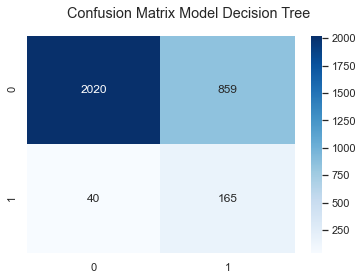

In [ ]:
cm = confusion_matrix(y_test2, train_apprx_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.suptitle("Confusion Matrix Model Decision Tree")
plt.show()

In [ ]:
# Calculate ROC AUC
probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
roc_auc = roc_auc_score(y_test2, probabilities)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print("ROC AUC Score:", roc_auc)
print('Specificity:', specificity)
print('Sensitivity:', sensitivity)

ROC AUC Score: 0.8217165513093131
Specificity: 0.7016325112886419
Sensitivity: 0.8048780487804879


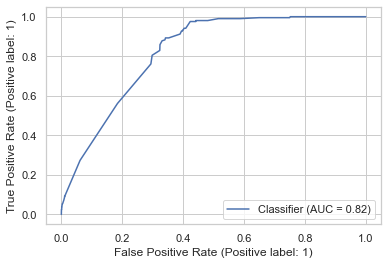

In [ ]:
RocCurveDisplay.from_predictions(y_test2, probabilities, pos_label=1)
plt.show()

In [ ]:
# roc_auc = []
# specificity = []
# sensitivity = []

# for i in range(5):
#     model_apprx_xgb.fit(df_train, feature_cols, label_name, model_xgb)

#     train_apprx_xgb = model_apprx_xgb.predict(x_test2)

#     # Calculate ROC AUC
#     probabilities = model_apprx_xgb.predict_proba(x_test2)[:, 1]
#     roc_auc = roc_auc_score(y_test2, probabilities)

#     cm = confusion_matrix(y_test2, train_apprx_xgb)
#     tn, fp, fn, tp = cm.ravel()
#     specificity = tn / (tn + fp)
#     sensitivity = tp / (tp + fn)

#     print(f"iteration{i+1}")
#     print(f"ROC_AUC{roc_auc}")
#     print(f"Specificity{specificity}")
#     print(f"Sensitivity{sensitivity}")
#     print(" ")

Start pruning


# Interpretasi Model

## Feature Importance

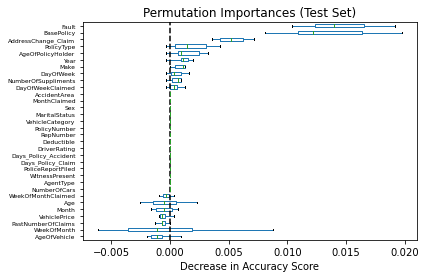

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(dt_pipeline, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_dt = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_dt[0:32]].T,
                           columns=feature_names[sorted_importances_idx_dt[0:32]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=6)

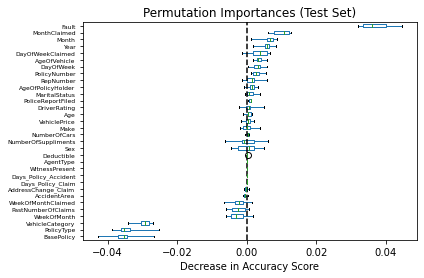

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_pipeline, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_rf = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_rf[0:32]].T,
                           columns=feature_names[sorted_importances_idx_rf[0:32]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=6)

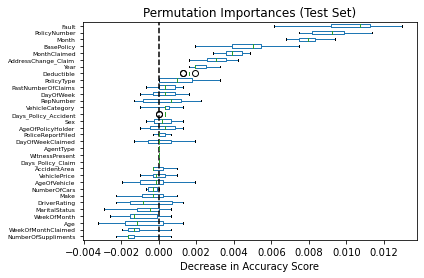

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_pipelines, x_test, y_test, n_repeats=10, random_state=1)

sorted_importances_idx_xgb = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx_xgb[0:32]].T,
                           columns=feature_names[sorted_importances_idx_xgb[0:32]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.tick_params(axis='y', labelsize=6)

In [ ]:
# COMMUNICATE the results
## Model interpretation: Permutation Feature Importance (PFI)
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, accuracy_score

scoring = make_scorer(accuracy_score)

result = permutation_importance(model_apprx_xgb, x_test2, y_test2, n_repeats=10, random_state=1,scoring=scoring)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx[0:14]].T,
                           columns=feature_names[sorted_importances_idx[0:14]])

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Test Set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")

KeyboardInterrupt: 

## PDPs

In [ ]:
numerical_features_sorted_dt = [feature_names[i] for i in sorted_importances_idx_dt if feature_names[i] in num_col]
numerical_features_sorted_dt.reverse()

numerical_features_sorted_rf = [feature_names[i] for i in sorted_importances_idx_rf if feature_names[i] in num_col]
numerical_features_sorted_rf.reverse()

numerical_features_sorted_xgb = [feature_names[i] for i in sorted_importances_idx_xgb if feature_names[i] in num_col]
numerical_features_sorted_xgb.reverse()

# numerical_features_sorted = [feature_names[i] for i in sorted_importances_idx if feature_names[i] in num_col]
# numerical_features_sorted.reverse()

print(numerical_features_sorted_dt)
print(numerical_features_sorted_rf)
print(numerical_features_sorted_xgb)

['Year', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'WeekOfMonthClaimed', 'Age', 'WeekOfMonth']
['Year', 'PolicyNumber', 'RepNumber', 'DriverRating', 'Age', 'Deductible', 'WeekOfMonthClaimed', 'WeekOfMonth']
['PolicyNumber', 'Year', 'Deductible', 'RepNumber', 'DriverRating', 'WeekOfMonth', 'Age', 'WeekOfMonthClaimed']


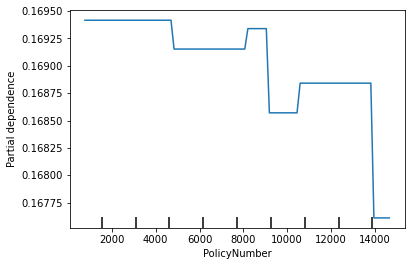

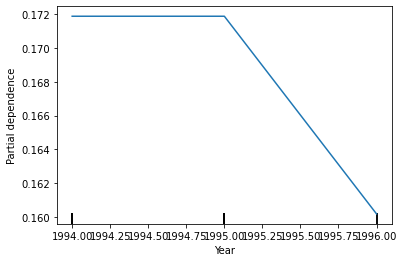

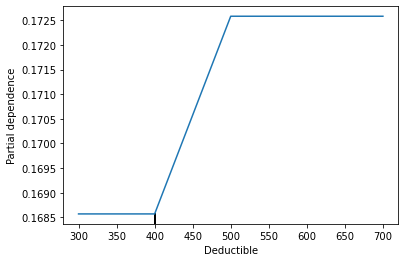

In [ ]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

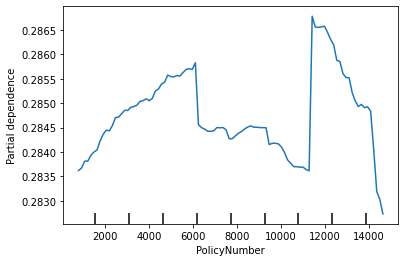

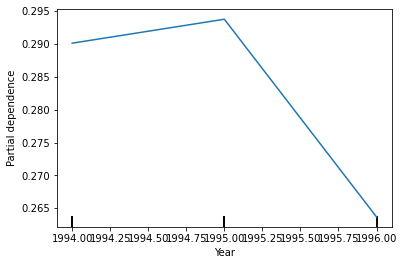

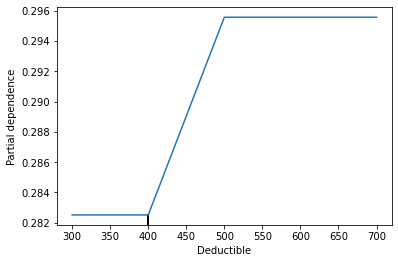

In [ ]:
PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

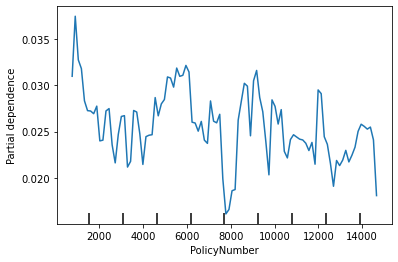

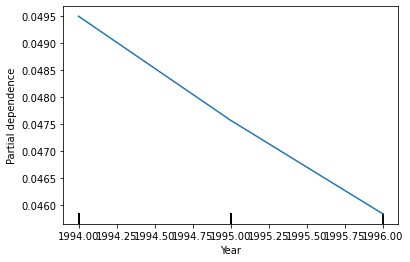

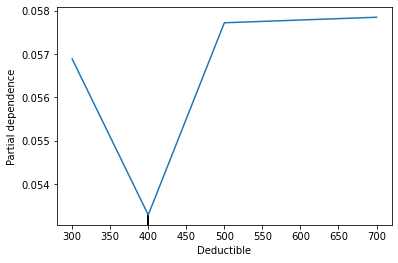

In [ ]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names)

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names)

## ICEs

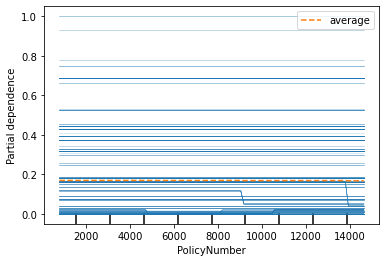

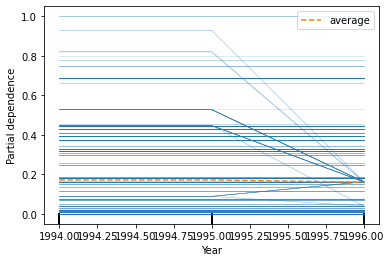

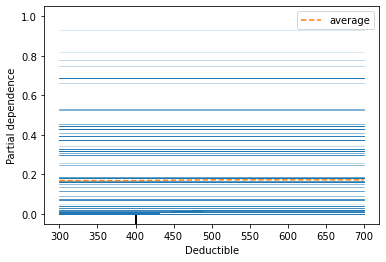

In [ ]:
PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(dt_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

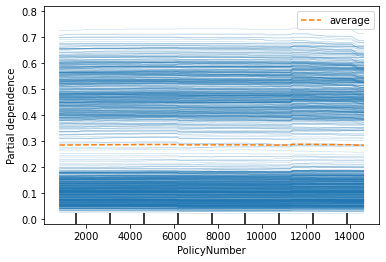

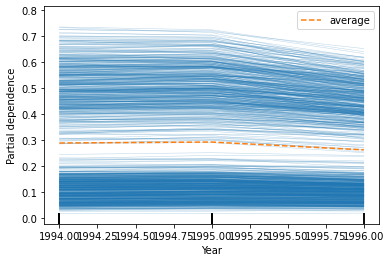

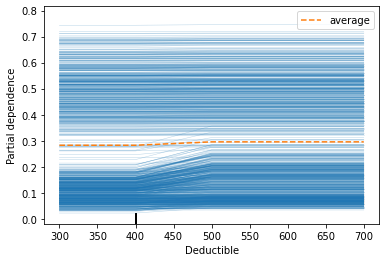

In [ ]:
PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(rf_pipeline, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

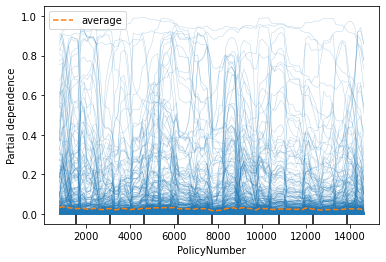

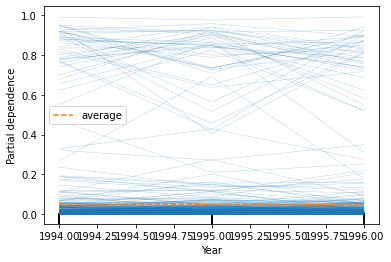

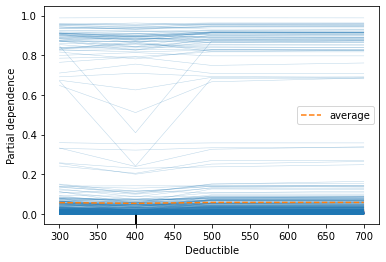

In [ ]:
PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[0])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[1])], feature_names=feature_names, kind='both')

PartialDependenceDisplay.from_estimator(xgb_pipelines, data, [(numerical_features_sorted_xgb[2])], feature_names=feature_names, kind='both')

# Transparent Model Interpretation

## Model Decision Tree

In [ ]:
model_dt = DecisionTreeClassifier(criterion='entropy',max_depth=9, min_samples_leaf=50, min_samples_split=100)

In [ ]:
# Show The Rule from Model

model_dt.fit(x_smote, y_smote)

rule = export_text(model_dt)
print(rule)

|--- feature_126 <= 1.00
|   |--- feature_55 <= 1.00
|   |   |--- feature_140 <= 0.00
|   |   |   |--- feature_57 <= 0.98
|   |   |   |   |--- feature_147 <= 0.99
|   |   |   |   |   |--- feature_142 <= 0.25
|   |   |   |   |   |   |--- feature_7 <= 0.01
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_7 >  0.01
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_142 >  0.25
|   |   |   |   |   |   |--- feature_11 <= 0.00
|   |   |   |   |   |   |   |--- feature_100 <= 0.00
|   |   |   |   |   |   |   |   |--- feature_142 <= 0.66
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_142 >  0.66
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_100 >  0.00
|   |   |   |   |   |   |   |   |--- feature_100 <= 0.96
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_100 >  0.96
|   |   |   |   |   |   |   |   |   |

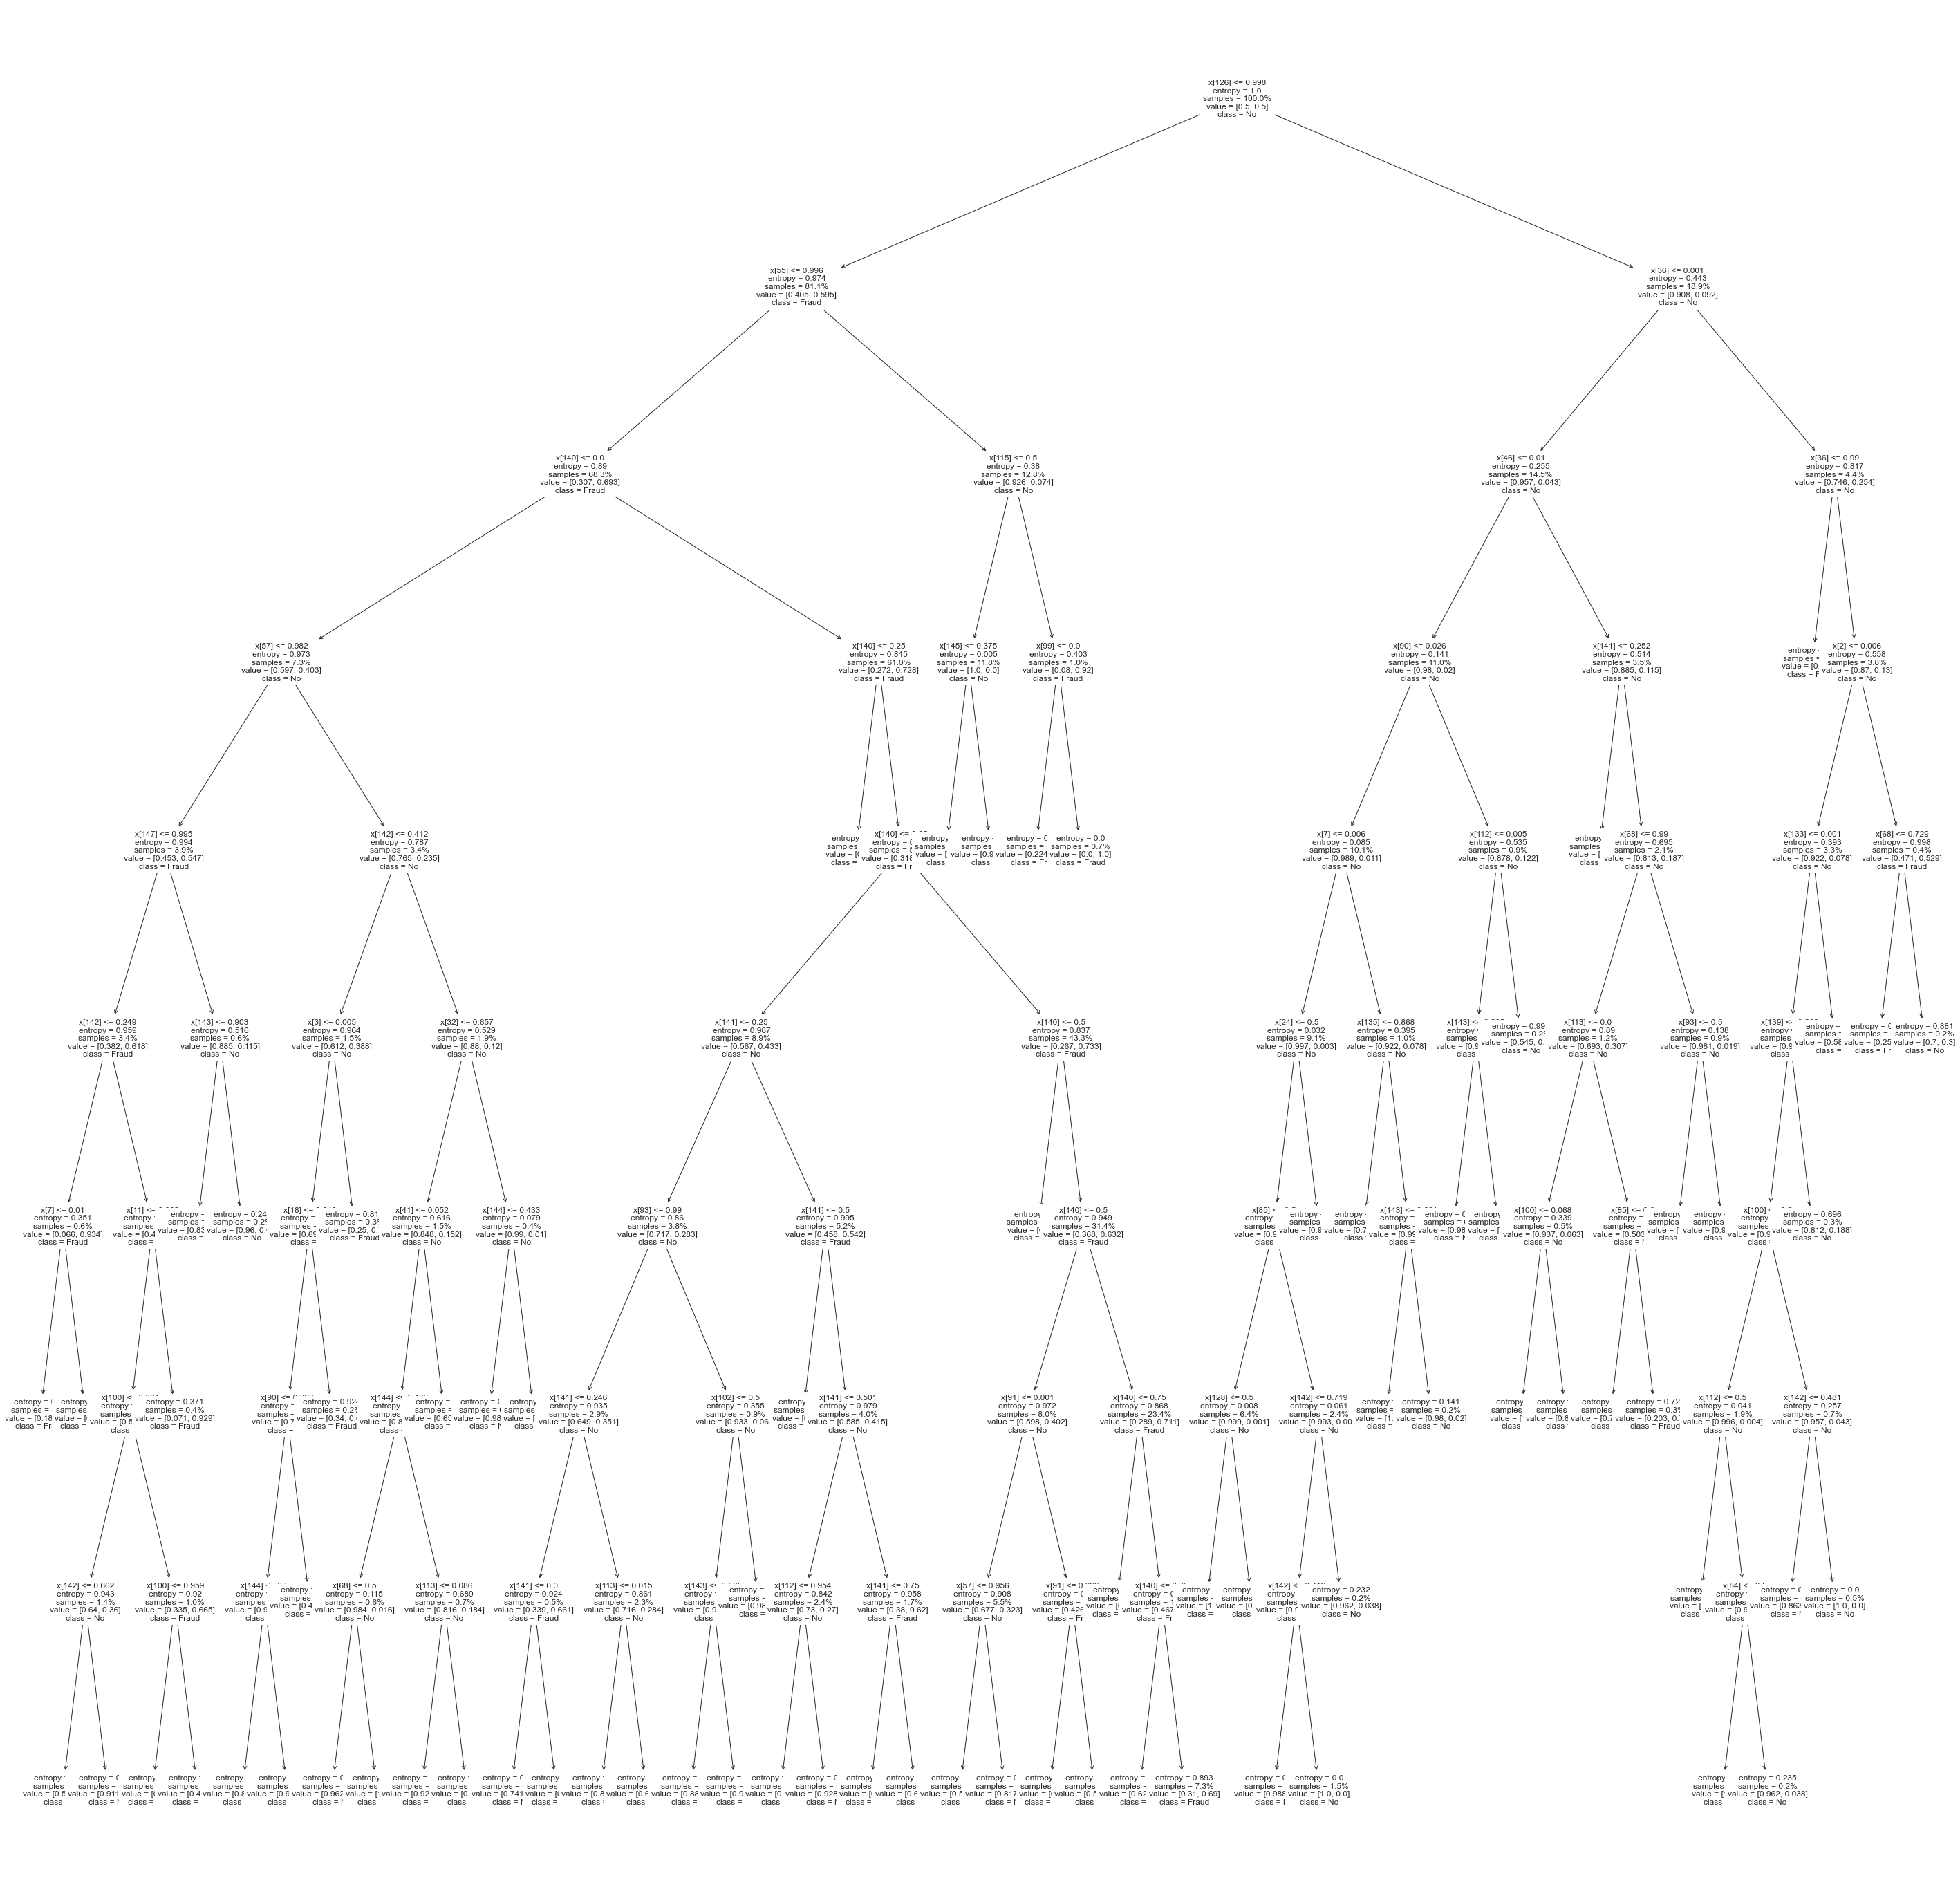

In [ ]:
# Show The Decision Tree
plt.figure(figsize=(50,50))
plot_tree(model_dt, fontsize=12, proportion=True,class_names=['No', 'Fraud'])
plt.show()

## Model Approximating XGBoost

In [ ]:
model_apprx_xgb.tree.print_tree(feature_cols)

|--- Fault_Policy Holder >= 0.00935271848
|   |--- BasePolicy_Liability >= 1.0
|   |   |--- Make_Toyota >= 0.00736888964
|   |   |   |--- Make_Toyota >= 0.984212041
|   |   |   |   |--- Month_Dec >= 0.00440133736
|   |   |   |   |   |--- Month_Dec >= 0.997117817
|   |   |   |   |   |   |--- NumberOfSuppliments_3 to 5 >= 0.00502179703
|   |   |   |   |   |   |   |--- PastNumberOfClaims_2 to 4 >= 0.00521653658
|   |   |   |   |   |   |   |   |--- RepNumber >= 0.666666687
|   |   |   |   |   |   |   |   |   |--- DayOfWeek_Thursday >= 0.00573020568
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- DayOfWeek_Thursday < 0.00573020568
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |--- RepNumber < 0.666666687
|   |   |   |   |   |   |   |   |   |--- DayOfWeek_Friday >= 0.00331461406
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- DayOfWeek_Friday < 

|   |   |   |   |   |   |   |   |   |--- PolicyType_Sedan - Collision < 0.997386694
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |--- Month_Jun < 0.993320405
|   |   |   |   |--- Year >= 0.272248775
|   |   |   |   |   |--- Year >= 0.478254944
|   |   |   |   |   |   |--- Year >= 0.483599395
|   |   |   |   |   |   |   |--- Year >= 0.491191328
|   |   |   |   |   |   |   |   |--- Year >= 0.498189688
|   |   |   |   |   |   |   |   |   |--- WeekOfMonth >= 0.299555302
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- WeekOfMonth < 0.299555302
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |--- Year < 0.498189688
|   |   |   |   |   |   |   |   |   |--- RepNumber >= 0.533333361
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- RepNumber < 0.533333361
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |

|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |--- Make_Pontiac < 0.00796006247
|   |   |   |   |   |   |   |--- VehiclePrice_20000 to 29000 >= 0.994687021
|   |   |   |   |   |   |   |   |--- PolicyNumber >= 0.722614944
|   |   |   |   |   |   |   |   |   |--- Month_Oct >= 0.00125622202
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- Month_Oct < 0.00125622202
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |--- PolicyNumber < 0.722614944
|   |   |   |   |   |   |   |   |   |--- Month_Jun >= 0.00137309718
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |   |   |--- Month_Jun < 0.00137309718
|   |   |   |   |   |   |   |   |   |   |--- result:  75.5
|   |   |   |   |   |   |   |--- VehiclePrice_20000 to 29000 < 0.994687021
|   |   |   |   |   |   |   |   |--- DayOfWeek_Tuesday >= 0.00641688798
|   |   |   |   |   |   |

In [ ]:
# Get the decision paths for the input data
paths = model_apprx_xgb.get_decision_paths(df)

# Print the decision paths
for i, path in enumerate(paths, start=1):
    print(f"Path {i}: {' -> '.join(path)}")

In [ ]:
plt.figure(figsize=(64,64))
plot_tree(model_apprx_xgb, fontsize=12, proportion=True,class_names=['No', 'Fraud'])
plt.show()